# 🩺 Clinical Decision Support System (DSS): Exploratory Data Analysis (EDA) and Machine Learning (ML)

**Team Members**: Joanna Chang, Lucas Huynh, Anshika Shukla
--
**Course**: 94409 - Healthcare Information Systems  
--
**Institution**: Carnegie Mellon University
--
**Date**: *April 2025*
---

### Objective

The purpose of this notebook is to conduct a comprehensive exploratory data analysis (EDA) of patient insurance data. This EDA provides insights into the key factors influencing insurance charges, identifies patterns and correlations among variables, and prepares the data for predictive modeling in our clinical DSS.

---

### Machine Learning Integration

A machine learning model (Gradient Boosting Regressor) was developed using this dataset to predict insurance charges based on patient features. After model tuning and evaluation, the best-performing model was serialized into a `.pkl` file (`best_gradient_boosting_model.pkl`) for seamless integration into our Streamlit user interface (UI) application.

---

### Overview

- Dataset overview and structure
- Distribution analysis of key features
- Correlation heatmaps
- SHAP value interpretation
- Visual exploration (scatterplots, boxplots, pairplots)
- Data transformations and skewness checks
- ML model performance evaluation and export to .pkl


## Packages to Import

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr, pointbiserialr, chi2_contingency
from scipy.stats import ttest_ind, f_oneway
from itertools import combinations
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import joblib
import shap
from sklearn.utils import resample

## 1. Data Loading, Preliminary Cleaning, and EDA

In [16]:
# Load the dataset
df = pd.read_csv("healthinsurance.csv")


In [17]:
# View the first few rows
display(df.head())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Summary Statistics

In [18]:
# Summary statistics
df.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


### Summary Interpretation

From the dataset of **1,338 patients**, we observe the following:

- **Age**: Patients range from 18 to 64 years old, with an average age of approximately **39.2**. The age distribution is relatively balanced, with 50% of patients under 39.
  
- **BMI**: The **mean BMI** is around **30.66**, which is classified as obese (≥30), suggesting a large portion of the patient population may be overweight or obese. The maximum BMI observed is **53.13**.
  
- **Children**: On average, patients have about **1.1 children**, with **25% having none**, and **75% having two or fewer**.
  
- **Smoking Status**: Only **274 patients** are smokers (**~20.5%**), while **1,064 patients** (~79.5%) do not smoke. This imbalance is important when evaluating the impact of smoking on insurance charges.
  
- **Region**: The most common region is the **southeast**, with **364 patients**, followed by other regions with smaller representation.
  
- **Charges**: Insurance charges range from **$1,121.87** to **$63,770.43**, with a **mean of $13,270.42**. However, the **median is only $9,382**, indicating a **right-skewed distribution** due to a small number of high-cost patients.

This statistical overview suggests that a few high-cost patients (likely older, smokers, or with high BMI) disproportionately raise the average insurance charge. These insights motivated the creation of a predictive DSS to identify key drivers and forecast costs more transparently.

### Checking for Sparse Columns and Missing Values

In [19]:
# Unique value counts
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [20]:
# Check for missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Unique Value Counts & Missing Data Check

- The dataset contains:
  - **47 unique ages**
  - **548 distinct BMI values**
  - **6 categories for number of children**
  - **2 sexes** and **2 smoking statuses**
  - **4 geographic regions**
  - **1,337 unique charge values** out of 1,338 records (almost all charges are unique)

- **No missing values** are present in the dataset across any column, indicating clean and complete data for modeling.


### Checking Data Types

In [21]:
# Data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Data Types Overview

The dataset consists of **1,338 records** across **7 columns**, with a mix of numerical and categorical features:

- **Numerical Columns (int64/float64)**:
  - `age`, `children` (int64)
  - `bmi`, `charges` (float64)

- **Categorical Columns (object)**:
  - `sex`, `smoker`, `region`

All columns are fully populated with **no missing values**, and memory usage is approximately **73 KB** — making it lightweight and suitable for quick exploratory analysis and modeling.


## 2. Plotting Feature Distributions

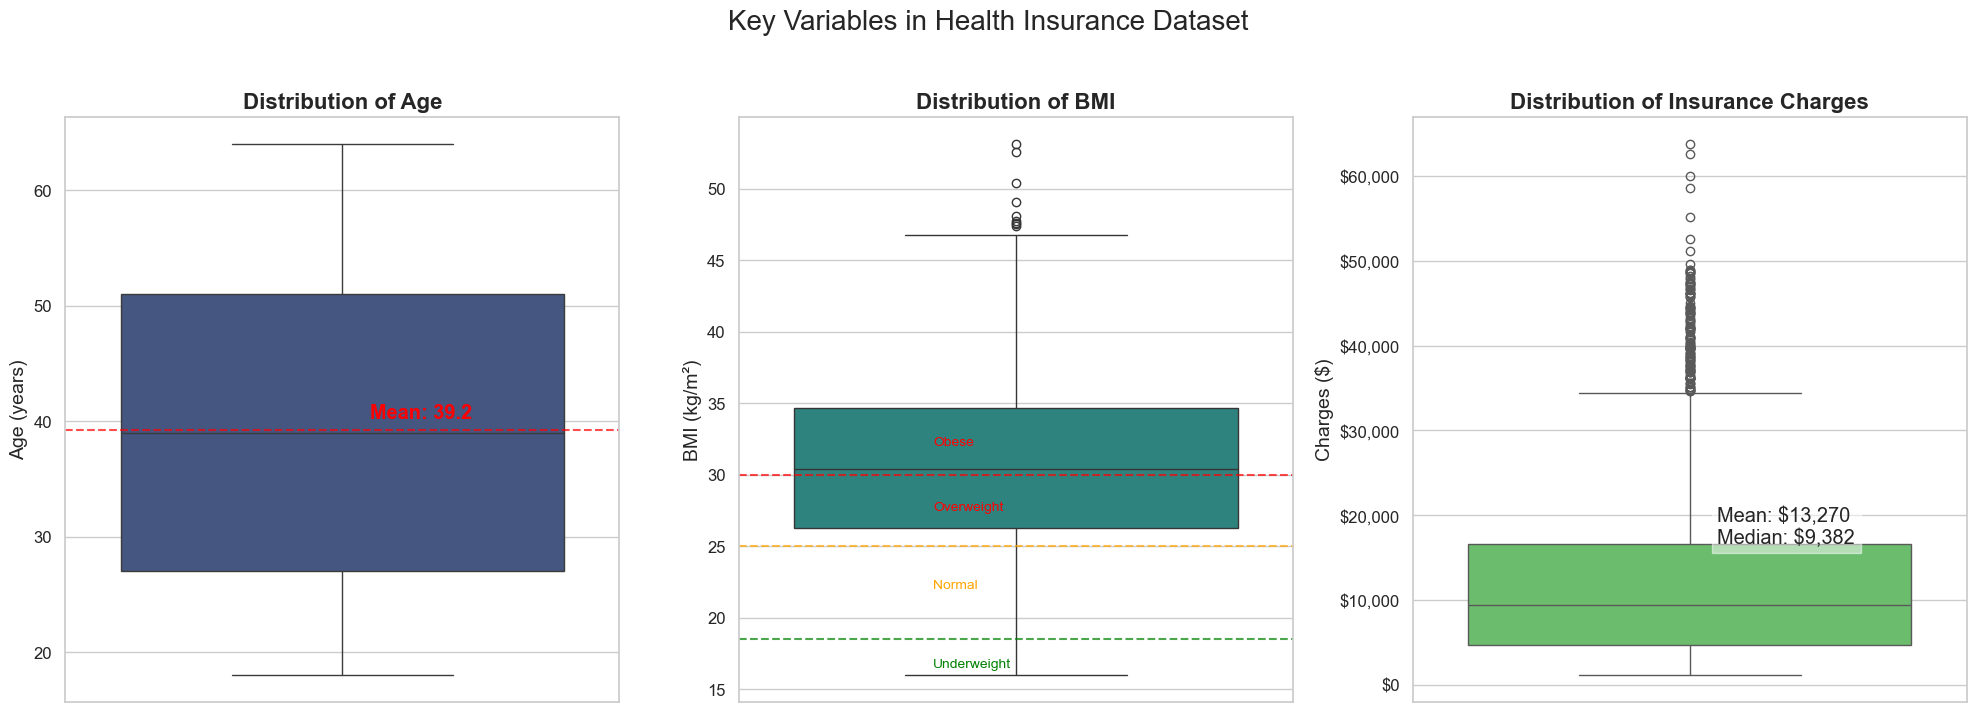

/var/folders/tj/f3l3_hgj4wng8cx7x4cwjzzc0000gn/T/ipykernel_61091/2883215970.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, palette=categorical_palette)
/var/folders/tj/f3l3_hgj4wng8cx7x4cwjzzc0000gn/T/ipykernel_61091/2883215970.py:62: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.countplot(x=col, data=df, palette=categorical_palette)


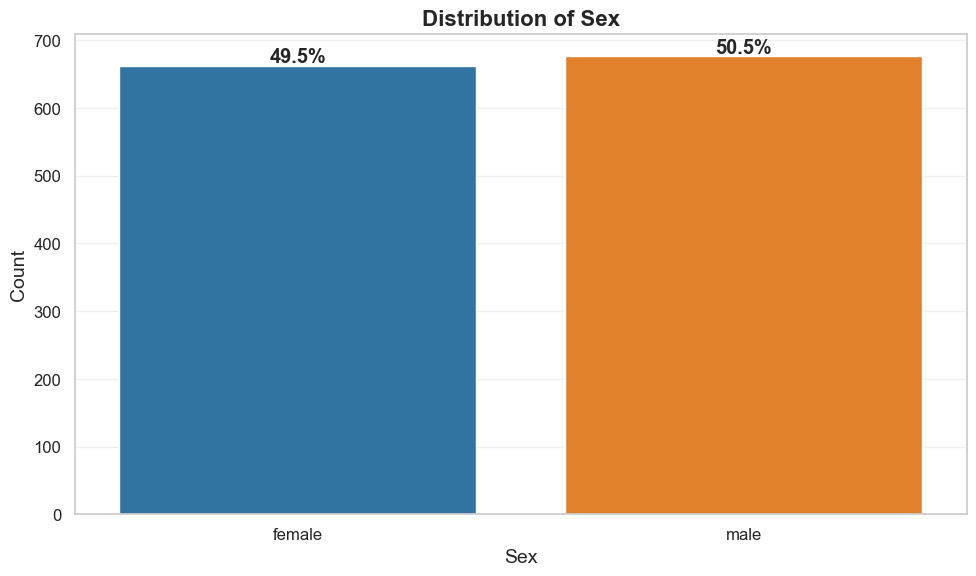

/var/folders/tj/f3l3_hgj4wng8cx7x4cwjzzc0000gn/T/ipykernel_61091/2883215970.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, palette=categorical_palette)
/var/folders/tj/f3l3_hgj4wng8cx7x4cwjzzc0000gn/T/ipykernel_61091/2883215970.py:62: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.countplot(x=col, data=df, palette=categorical_palette)


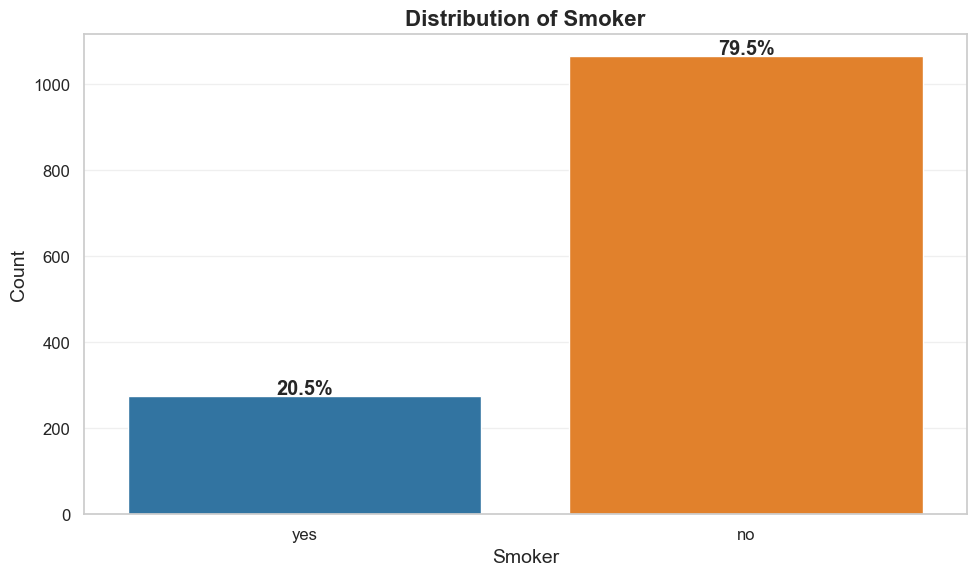

/var/folders/tj/f3l3_hgj4wng8cx7x4cwjzzc0000gn/T/ipykernel_61091/2883215970.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, palette=categorical_palette)
/var/folders/tj/f3l3_hgj4wng8cx7x4cwjzzc0000gn/T/ipykernel_61091/2883215970.py:62: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.countplot(x=col, data=df, palette=categorical_palette)


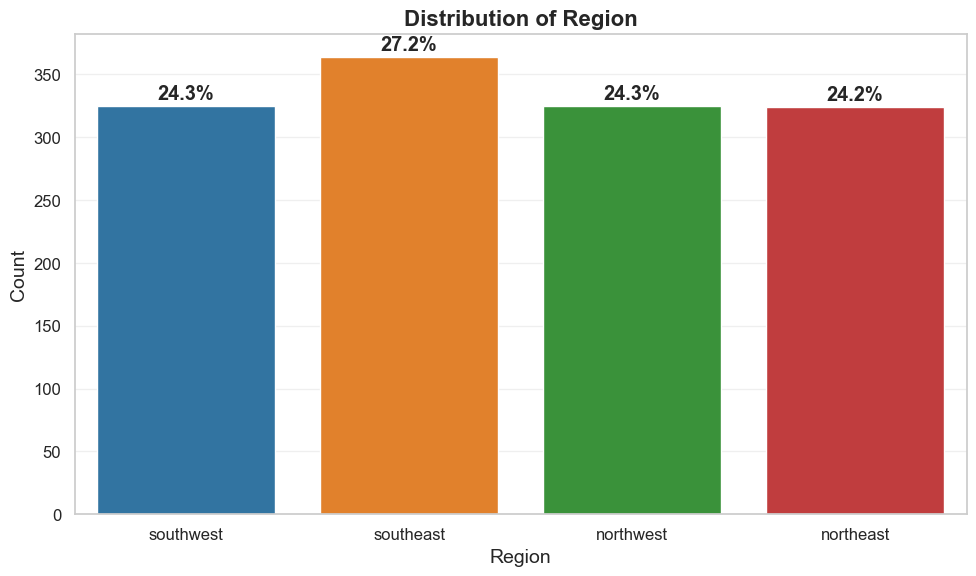

/var/folders/tj/f3l3_hgj4wng8cx7x4cwjzzc0000gn/T/ipykernel_61091/2883215970.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, palette=categorical_palette)
/var/folders/tj/f3l3_hgj4wng8cx7x4cwjzzc0000gn/T/ipykernel_61091/2883215970.py:62: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  ax = sns.countplot(x=col, data=df, palette=categorical_palette)


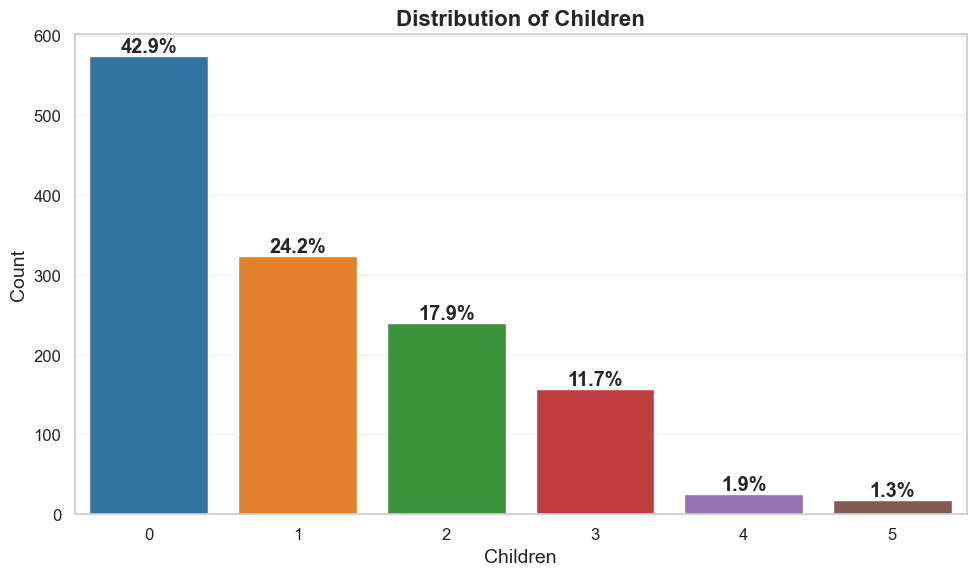

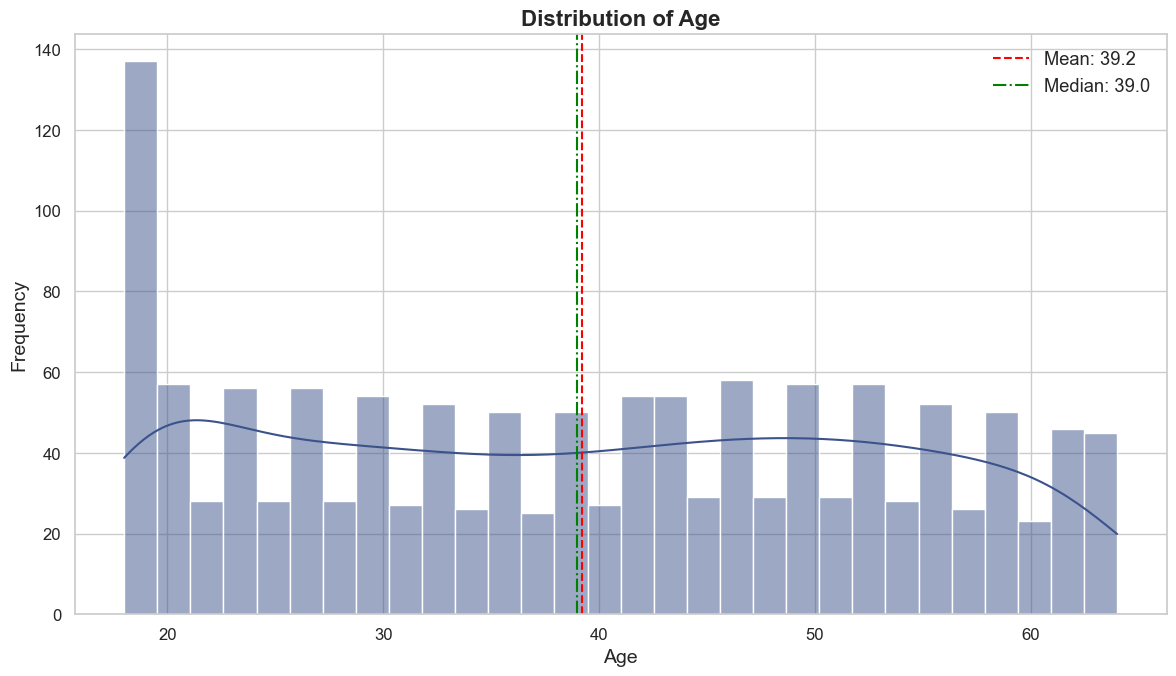

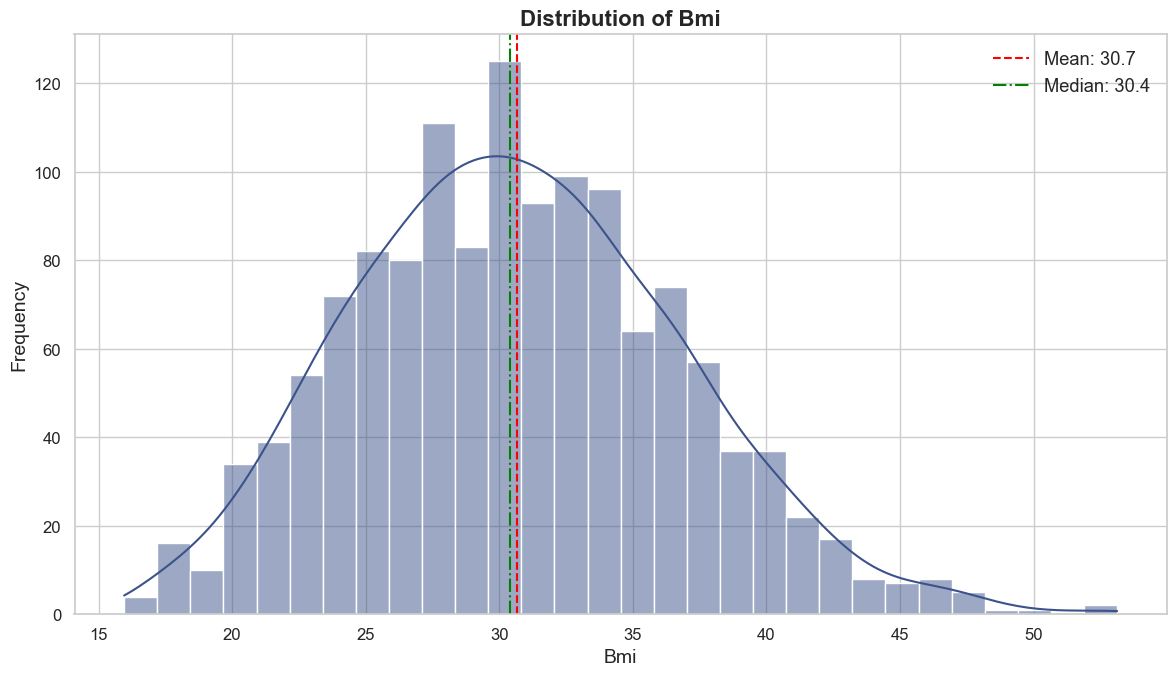

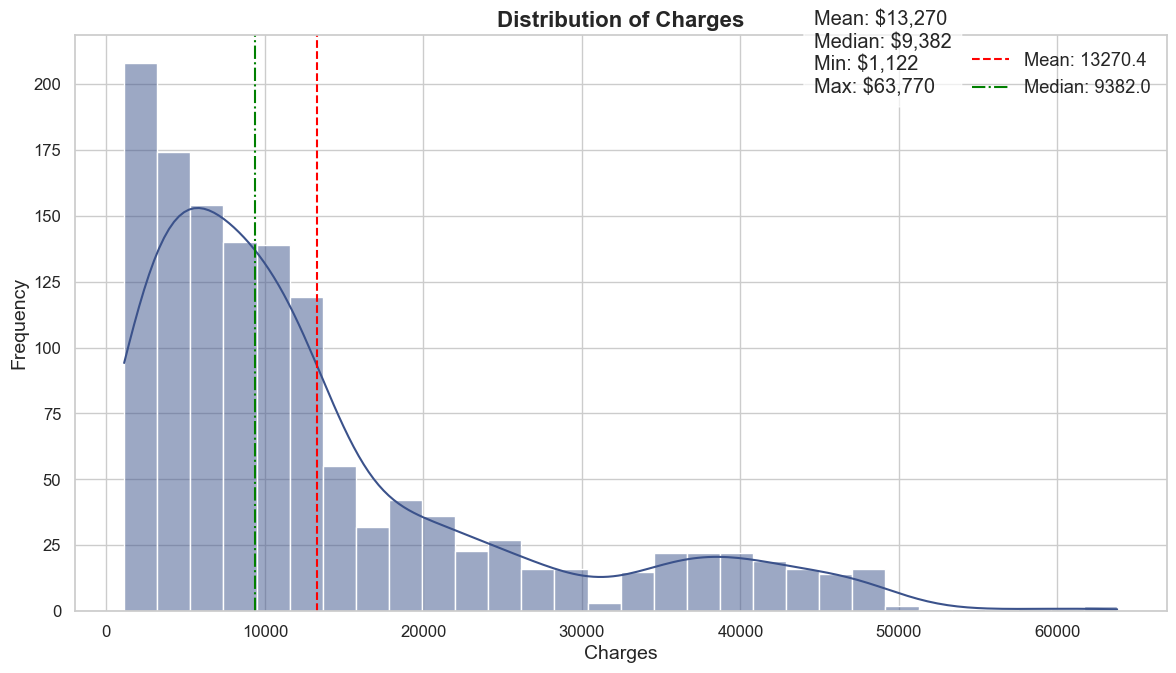

/var/folders/tj/f3l3_hgj4wng8cx7x4cwjzzc0000gn/T/ipykernel_61091/2883215970.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x="smoker", y="charges", data=df, palette=['#3498db', '#e74c3c'], inner='quartile')


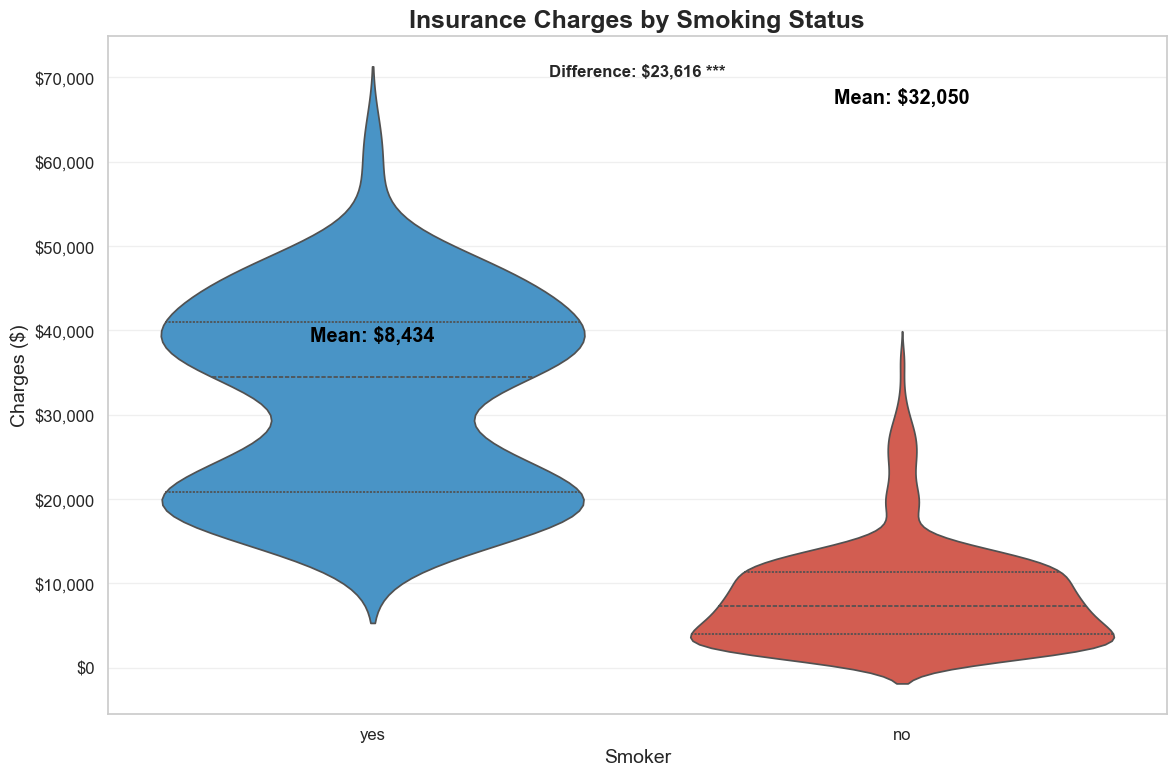

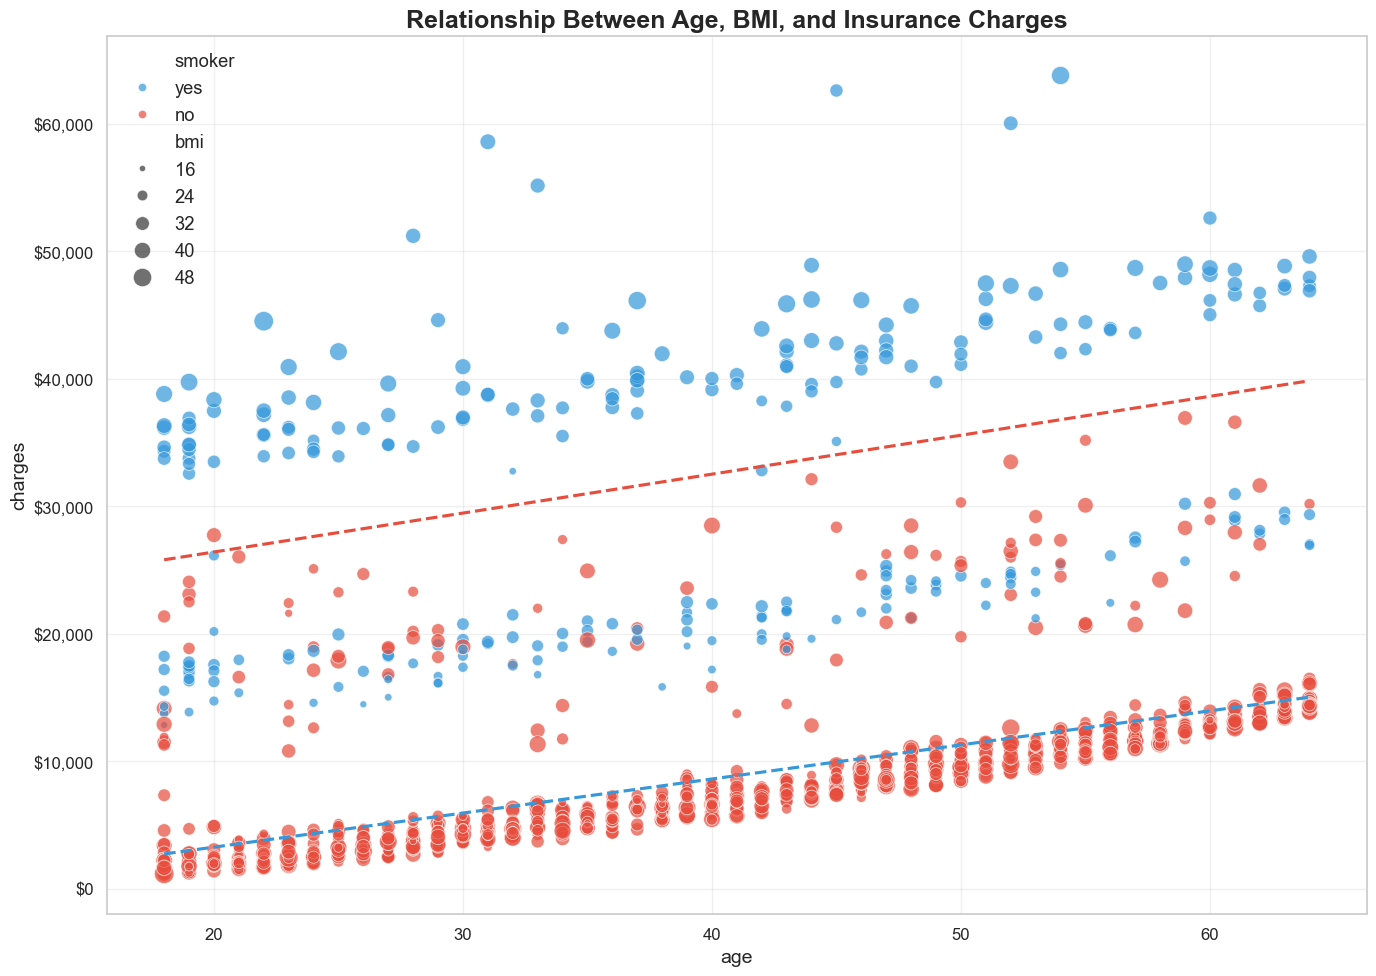

In [41]:
# Set the style for better visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set a more modern style with better aesthetics
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Color palettes
main_palette = sns.color_palette("viridis", 3)
categorical_palette = sns.color_palette("tab10")

# 1. Enhanced boxplots with statistical annotations
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Age boxplot
sns.boxplot(y=df['age'], ax=axes[0], color=main_palette[0])
axes[0].set_title('Distribution of Age', fontweight='bold')
axes[0].set_ylabel('Age (years)')
# Add mean line and annotation
mean_age = df['age'].mean()
axes[0].axhline(mean_age, color='red', linestyle='--', alpha=0.7)
axes[0].text(0.05, mean_age + 1, f'Mean: {mean_age:.1f}', color='red', fontweight='bold')

# BMI boxplot
sns.boxplot(y=df['bmi'], ax=axes[1], color=main_palette[1])
axes[1].set_title('Distribution of BMI', fontweight='bold')
axes[1].set_ylabel('BMI (kg/m²)')
# Add WHO BMI category lines
axes[1].axhline(18.5, color='green', linestyle='--', alpha=0.7)
axes[1].axhline(25, color='orange', linestyle='--', alpha=0.7)
axes[1].axhline(30, color='red', linestyle='--', alpha=0.7)
axes[1].text(-0.15, 16.5, 'Underweight', color='green', fontsize=10)
axes[1].text(-0.15, 22, 'Normal', color='orange', fontsize=10)
axes[1].text(-0.15, 27.5, 'Overweight', color='red', fontsize=10)
axes[1].text(-0.15, 32, 'Obese', color='red', fontsize=10)

# Charges boxplot
sns.boxplot(y=df['charges'], ax=axes[2], color=main_palette[2])
axes[2].set_title('Distribution of Insurance Charges', fontweight='bold')
axes[2].set_ylabel('Charges ($)')
# Format y-axis with commas for thousands
axes[2].yaxis.set_major_formatter('${x:,.0f}')

# Add a summary stats annotation
stats = f"Mean: ${df['charges'].mean():,.0f}\nMedian: ${df['charges'].median():,.0f}"
axes[2].text(0.05, df['charges'].quantile(0.75), stats, bbox=dict(facecolor='white', alpha=0.5))

plt.suptitle('Key Variables in Health Insurance Dataset', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

# 2. Enhanced categorical plots with percentages
for col in ['sex', 'smoker', 'region', 'children']:
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=col, data=df, palette=categorical_palette)
    plt.title(f"Distribution of {col.title()}", fontweight='bold')
    plt.xlabel(col.title())
    plt.ylabel("Count")
    
    # Add percentage labels
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        percentage = f'{100 * height/total:.1f}%'
        ax.text(p.get_x() + p.get_width()/2., height + 5, percentage, 
                ha="center", fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 3. Enhanced KDE plots with summary statistics
for col in ['age', 'bmi', 'charges']:
    plt.figure(figsize=(12, 7))
    
    # Create the KDE plot
    sns.histplot(df[col], kde=True, bins=30, color=main_palette[0])
    
    # Add vertical lines for key statistics
    plt.axvline(df[col].mean(), color='red', linestyle='--', label=f'Mean: {df[col].mean():.1f}')
    plt.axvline(df[col].median(), color='green', linestyle='-.', label=f'Median: {df[col].median():.1f}')
    
    # Format titles and labels
    plt.title(f"Distribution of {col.title()}", fontweight='bold')
    plt.xlabel(col.title())
    plt.ylabel("Frequency")
    
    # Add a summary box
    if col == 'charges':
        stats = (f"Mean: ${df[col].mean():,.0f}\n"
                f"Median: ${df[col].median():,.0f}\n"
                f"Min: ${df[col].min():,.0f}\n"
                f"Max: ${df[col].max():,.0f}")
        plt.text(df[col].max()*0.7, plt.gca().get_ylim()[1]*0.9, stats, 
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'))
    
    plt.legend()
    plt.tight_layout()
    plt.show()

# 4. Enhanced violin plot for charges by smoker status
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x="smoker", y="charges", data=df, palette=['#3498db', '#e74c3c'], inner='quartile')
plt.title("Insurance Charges by Smoking Status", fontsize=18, fontweight='bold')
plt.xlabel("Smoker", fontsize=14)
plt.ylabel("Charges ($)", fontsize=14)

# Format y-axis with commas
ax.yaxis.set_major_formatter('${x:,.0f}')

# Add means and statistical annotation
for i, smoker in enumerate(['no', 'yes']):
    subset = df[df['smoker'] == smoker]
    mean_val = subset['charges'].mean()
    plt.text(i, subset['charges'].max()*1.05, f'Mean: ${mean_val:,.0f}', 
            ha='center', fontweight='bold', color='black')

# Add a t-test annotation
from scipy import stats
smoker_charges = df[df['smoker'] == 'yes']['charges']
nonsmoker_charges = df[df['smoker'] == 'no']['charges']
t_stat, p_val = stats.ttest_ind(smoker_charges, nonsmoker_charges)
significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"

plt.text(0.5, df['charges'].max()*1.1, 
        f'Difference: ${smoker_charges.mean() - nonsmoker_charges.mean():,.0f} {significance}', 
        ha='center', fontsize=12, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 5. New plot: Relationship between age, BMI and charges with smoker status
plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(x="age", y="charges", hue="smoker", size="bmi", 
                        sizes=(20, 200), palette=["#3498db", "#e74c3c"], 
                        alpha=0.7, data=df)
plt.title("Relationship Between Age, BMI, and Insurance Charges", fontsize=18, fontweight='bold')
plt.xlabel("Age (years)", fontsize=14)
plt.ylabel("Charges ($)", fontsize=14)

# Format y-axis with commas
scatter.yaxis.set_major_formatter('${x:,.0f}')

# Add a regression line for each smoker category
sns.regplot(x="age", y="charges", data=df[df['smoker']=='yes'], 
           scatter=False, ci=None, color="#e74c3c", line_kws={"linestyle":"--"})
sns.regplot(x="age", y="charges", data=df[df['smoker']=='no'], 
           scatter=False, ci=None, color="#3498db", line_kws={"linestyle":"--"})

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Distribution Analysis

#### 1. Distribution of Age
- **Shape:** Right-skewed with a sharp spike around age 18.
- **Observation:** Significantly more individuals aged 18 compared to other age groups. The rest of the distribution is relatively uniform.
- **Interpretation:** The spike at age 18 may suggest a large group of young adults, possibly students or dependents.

#### 2. Distribution of BMI
- **Shape:** Roughly bell-shaped; resembles a normal distribution.
- **Observation:** Most individuals have a BMI between 25 and 35.
- **Interpretation:** A large portion of the dataset is either overweight or mildly obese.

#### 3. Distribution of Charges
- **Shape:** Heavily right-skewed.
- **Observation:** Most individuals are charged under $10,000, with a long tail extending beyond $60,000.
- **Interpretation:** A small number of patients have serious or chronic health issues driving high costs.

---

### Transformation of Data

#### 1. Charges
- **Observation:** Highly skewed.
- **Recommendation:** Apply `np.log(charges)` or `np.log1p(charges)` to stabilize variance and improve model performance.

#### 2. Age
- **Observation:** Mild skew due to spike at 18.
- **Recommendation:** Log transformation not necessary. Consider binning or separate treatment for age 18 if it represents a distinct population.

---

### Categorical Distributions

- **Sex:** Nearly equal distribution between male and female.
- **Smoker:** Only ~20% of patients are smokers, but they have notably higher charges.
- **Region:** Fairly balanced across the 4 U.S. regions, with a slight edge to the southeast.
- **Children:** Most patients have between 0–2 children; few have 4 or more.

---

### Violin Plot for Smoker Status

The violin plot is used specifically for smoker status in this case because the goal is likely to explore the relationship between smoking status (a categorical variable) and charges (a numerical variable). Smoking status is a key factor that could significantly influence medical charges, as smokers often incur higher healthcare costs due to smoking-related health issues. Moreover, according to the count plots, there is a large difference in the number of smokers and non-smokers.

**Observation:**  
Smokers tend to have **substantially higher medical charges**, with a wider and more right-skewed distribution. Non-smokers mostly fall under the $15,000 mark, while smokers frequently exceed it.

---


## 3. Correlation Analysis with Various Methods

In [23]:
target = df['charges']
correlations = {}

# Variable categorization
binary_variables = ['sex', 'smoker']
ordinal_variables = ['children']
continuous_variables = ['age', 'bmi']
categorical_variables = ['region']

# Encode binary variables for correlation
df['sex_encoded'] = df['sex'].map({'male': 1, 'female': 0})
df['smoker_encoded'] = df['smoker'].map({'yes': 1, 'no': 0})

# Phi Coefficient for binary
for col in ['sex_encoded', 'smoker_encoded']:
    correlations[col.replace('_encoded', '')] = pointbiserialr(df[col], target)[0]

# Spearman for ordinal
for col in ordinal_variables:
    correlations[col] = spearmanr(df[col], target)[0]

# Point-Biserial for continuous
for col in continuous_variables:
    correlations[col] = pointbiserialr(df[col] > df[col].median(), target)[0]

# Cramér's V for categorical
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k, r) - 1)))

for col in categorical_variables:
    contingency = pd.crosstab(df[col], pd.qcut(target, q=4))  # binning charges into quartiles
    correlations[col] = cramers_v(contingency)

# Convert to DataFrame for display
correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation with Charges'])
correlation_df = correlation_df.sort_values(by='Correlation with Charges', ascending=False)
correlation_df

,Correlation with Charges
smoker,0.787251
age,0.259102
bmi,0.198103
children,0.133339
region,0.071798
sex,0.057292


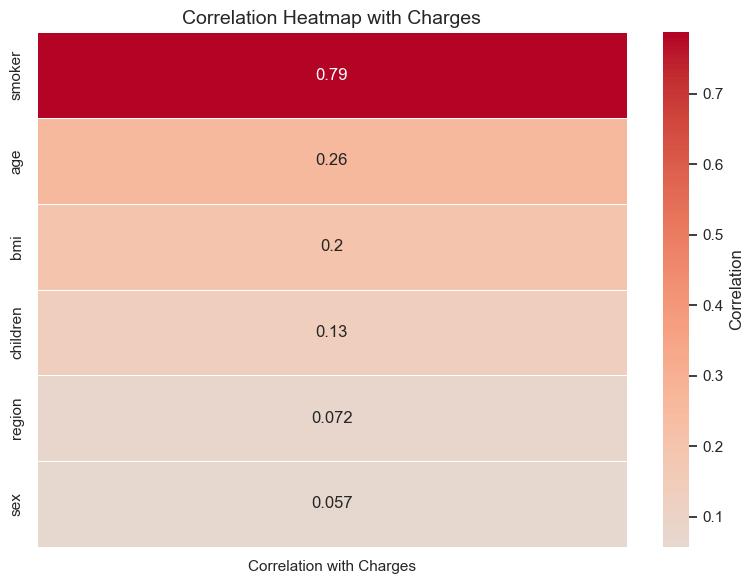

In [24]:
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_df,
    annot=True,
    cmap='coolwarm',
    center=0,
    cbar_kws={'label': 'Correlation'},
    linewidths=0.5
)
plt.title("Correlation Heatmap with Charges", fontsize=14)
plt.ylabel("")
plt.tight_layout()
plt.show()

### Correlation
Smoker status has a high positive correlation with Charges.

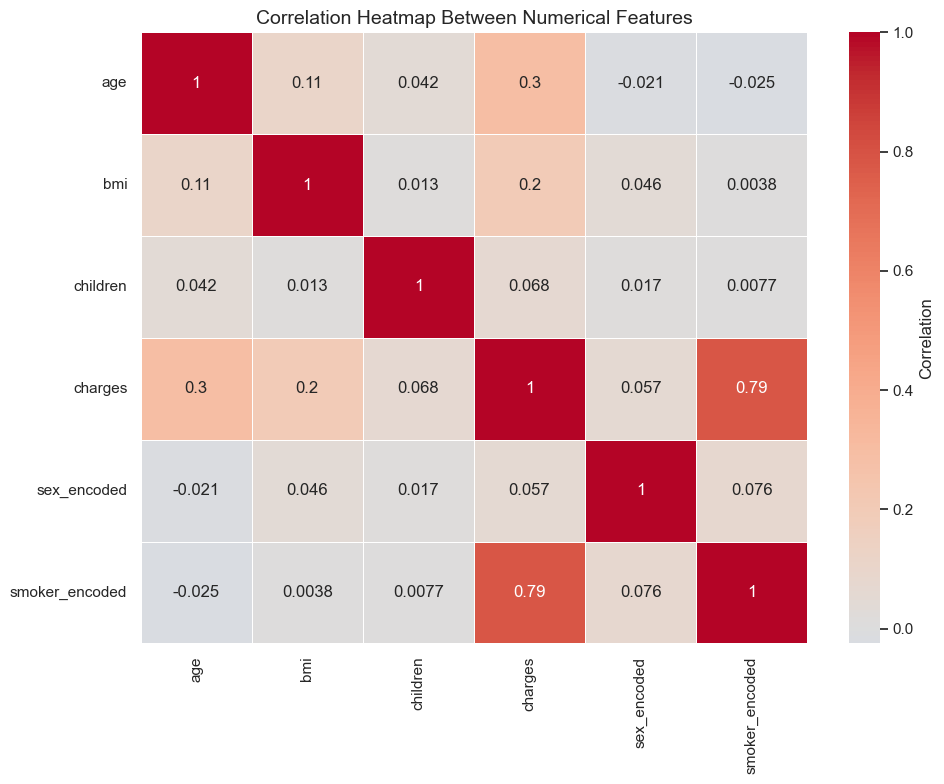

In [25]:
# Compute the full correlation matrix for numerical features only
full_corr_matrix = df.corr(numeric_only=True)

# Plot the full correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    full_corr_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation'}
)
plt.title("Correlation Heatmap Between Numerical Features", fontsize=14)
plt.tight_layout()
plt.show()

In [26]:
# Function to calculate Cohen's d
def cohens_d(group1, group2):
    diff = np.mean(group1) - np.mean(group2)
    pooled_sd = np.sqrt(((np.std(group1, ddof=1) ** 2) + (np.std(group2, ddof=1) ** 2)) / 2)
    return diff / pooled_sd

# Function to calculate eta squared from ANOVA
def eta_squared(anova_stat, df_between, df_total):
    return anova_stat * df_between / (anova_stat * df_between + df_total)

# Initialize result dictionary
statistical_tests = {}

# Continuous predictors: Spearman (effect size = correlation)
for col in ['age', 'bmi', 'children']:
    corr, pval = spearmanr(df[col], df['charges'])
    statistical_tests[col] = {
        "Test": "Spearman",
        "Statistic": corr,
        "p-value": pval,
        "Effect Size": abs(corr)
    }

# Binary predictors: Independent t-test + Cohen's d
for col in ['sex', 'smoker']:
    groups = df.groupby(col)['charges']
    g1, g2 = groups.get_group(df[col].unique()[0]), groups.get_group(df[col].unique()[1])
    stat, pval = ttest_ind(g1, g2, equal_var=False)
    d = cohens_d(g1, g2)
    statistical_tests[col] = {
        "Test": "t-test",
        "Statistic": stat,
        "p-value": pval,
        "Effect Size": abs(d)
    }

# Categorical predictor: ANOVA + eta squared
grouped = [group['charges'].values for name, group in df.groupby('region')]
stat, pval = f_oneway(*grouped)
df_between = len(grouped) - 1
df_total = len(df) - 1
eta2 = eta_squared(stat, df_between, df_total)
statistical_tests['region'] = {
    "Test": "ANOVA",
    "Statistic": stat,
    "p-value": pval,
    "Effect Size": eta2
}

# Convert to DataFrame and sort
stat_test_df = pd.DataFrame(statistical_tests).T
stat_test_df = stat_test_df.sort_values(by='p-value')

# Display result
print(stat_test_df)



              Test  Statistic   p-value Effect Size
smoker      t-test  32.751888       0.0     2.56807
age       Spearman   0.534392       0.0    0.534392
children  Spearman   0.133339  0.000001    0.133339
bmi       Spearman   0.119396  0.000012    0.119396
region       ANOVA   2.969627  0.030893    0.006619
sex         t-test  -2.100888  0.035841    0.114784


### Insights

Smoking status is by far the strongest predictor of higher medical charges, both statistically and practically.
Age also has a moderate positive relationship — as people age, they tend to have higher charges.
BMI and number of children have minor effects.
Sex and region show statistical significance, but their practical impact is limited (tiny effect sizes).

### Recommendation for Modeling

Include smoker and age for sure — they're both important predictors.
Consider including sex and region for completeness, but don't expect them to contribute much to model performance.
You may also log-transform charges to normalize its distribution before applying linear models.

In [27]:
feature_relationships = []

# Define variable types
continuous_vars = ['age', 'bmi', 'children']
categorical_vars = ['sex', 'smoker', 'region']
binary_categoricals = ['sex', 'smoker']

# 1. Continuous vs Continuous → Spearman correlation
for var1, var2 in combinations(continuous_vars, 2):
    stat, pval = spearmanr(df[var1], df[var2])
    feature_relationships.append({
        "Feature A": var1,
        "Feature B": var2,
        "Test": "Spearman",
        "Statistic": stat,
        "p-value": pval
    })

# 2. Categorical vs Categorical → Chi-square
for var1, var2 in combinations(categorical_vars, 2):
    contingency = pd.crosstab(df[var1], df[var2])
    stat, pval, _, _ = chi2_contingency(contingency)
    feature_relationships.append({
        "Feature A": var1,
        "Feature B": var2,
        "Test": "Chi-square",
        "Statistic": stat,
        "p-value": pval
    })

# 3a. Binary Categorical vs Continuous → Point-Biserial
for cat in binary_categoricals:
    for cont in continuous_vars:
        binary_map = {df[cat].unique()[0]: 0, df[cat].unique()[1]: 1}
        encoded = df[cat].map(binary_map)
        stat, pval = pointbiserialr(encoded, df[cont])
        feature_relationships.append({
            "Feature A": cat,
            "Feature B": cont,
            "Test": "Point-Biserial",
            "Statistic": stat,
            "p-value": pval
        })

# 3b. Region (multiclass) vs Continuous → ANOVA
for cont in continuous_vars:
    groups = [g[cont].values for _, g in df.groupby('region')]
    stat, pval = f_oneway(*groups)
    feature_relationships.append({
        "Feature A": 'region',
        "Feature B": cont,
        "Test": "ANOVA",
        "Statistic": stat,
        "p-value": pval
    })

# Convert to DataFrame and sort by p-value
feature_rel_df = pd.DataFrame(feature_relationships)
feature_rel_df = feature_rel_df.sort_values(by='p-value').reset_index(drop=True)

# Format p-values: use scientific notation only for very small values (e.g., < 0.001)
def format_p(p):
    return f"{p:.4f}" if p >= 0.001 else f"{p:.2e}"

# Apply formatting
feature_rel_df['p-value'] = feature_rel_df['p-value'].apply(format_p)

feature_rel_df


,Feature A,Feature B,Test,Statistic,p-value
0,region,bmi,ANOVA,39.495057,1.88e-24
1,age,bmi,Spearman,0.107736,7.86e-05
2,sex,smoker,Chi-square,7.392911,0.0065
3,age,children,Spearman,0.056992,0.0371
4,smoker,region,Chi-square,7.343478,0.0617
5,sex,bmi,Point-Biserial,0.046371,0.0900
6,smoker,age,Point-Biserial,0.025019,0.3605
7,sex,age,Point-Biserial,-0.020856,0.4459
8,sex,children,Point-Biserial,0.017163,0.5305
9,region,children,ANOVA,0.717493,0.5416


### Results
1. BMI differs significantly across regions
2. Slight positive correlation between age and BMI
3. Sex and smoking status are related
4. Age slightly correlates with number of children

### Correlation and Statistical Association with Charges Overview

To better understand the drivers of insurance charges, we analyzed the relationship between `charges` and other patient attributes using both correlation coefficients and statistical tests.

#### Correlation Analysis

We calculated the strength of association between `charges` and other features using appropriate statistical measures based on the type of variable:

- **Binary variables** (`sex`, `smoker`): Point-Biserial Correlation  
- **Ordinal variables** (`children`): Spearman Correlation  
- **Continuous variables** (`age`, `bmi`): Point-Biserial Correlation on binarized values  
- **Categorical variables** (`region`): Cramér’s V with quartile-binned charges  

The correlations are visualized in the heatmap below, where the most impactful feature is clearly `smoker` (0.79), followed by `age` (0.26) and `bmi` (0.20):

| **Feature** | **Correlation with Charges** |
|-------------|-------------------------------|
| smoker      | 0.79                          |
| age         | 0.26                          |
| bmi         | 0.20                          |
| children    | 0.13                          |
| region      | 0.07                          |
| sex         | 0.057                         |

This insight confirms the strong influence of smoking on medical expenses, while variables like sex and region have minimal impact.

---

#### Statistical Significance Tests

To complement the correlation analysis, we conducted statistical significance tests:

| **Variable** | **Test**     | **Statistic** | **p-value** | **Effect Size** |
|--------------|--------------|----------------|-------------|------------------|
| smoker       | t-test       | 32.75          | 0.000       | 2.57             |
| age          | Spearman     | 0.53           | 0.000       | 0.53             |
| children     | Spearman     | 0.13           | 0.00001     | 0.13             |
| bmi          | Spearman     | 0.12           | 0.000012    | 0.12             |
| region       | ANOVA        | 2.97           | 0.030       | 0.0066           |
| sex          | t-test       | -2.10          | 0.036       | 0.11             |

- **Smoker** status had a **very large effect** and was statistically significant.  
- **Age**, **bmi**, and **children** also had significant correlations, but their effect sizes were more modest.  
- **Region** and **sex** were statistically significant, but the effect sizes were small—indicating limited practical influence.

---

#### Pairwise Association Testing

To further understand how features interact with each other, we performed **pairwise association tests** between all independent variables. This was crucial not only to detect potential **multicollinearity** (which can hurt model performance) but also to reveal meaningful relationships between patient characteristics.

The following statistical tests were used based on the data types of the variables:

- **ANOVA (Analysis of Variance)**: For testing relationships between a categorical and a continuous variable  
- **Spearman Correlation**: For monotonic relationships between two ordinal or continuous variables  
- **Chi-Square Test of Independence**: For relationships between two categorical variables  
- **Point-Biserial Correlation**: For relationships between binary and continuous variables

##### Key Insights:

- **Region and BMI** showed a **highly significant association** (`ANOVA, p < 0.001`). This suggests that average BMI differs across geographic regions. This could reflect broader socioeconomic or cultural patterns affecting health.
  
- **Sex and Smoker Status** had a **statistically significant relationship** (`Chi-square, p = 0.0065`), indicating that smoking habits may differ by gender.

- **Age and BMI** had a **weak but significant positive correlation** (`Spearman, p < 0.0001`). As age increases, BMI tends to increase slightly, which aligns with common medical observations.

- Other relationships, such as **region vs. children** or **smoker vs. children**, were **not statistically significant**. This suggests those variables are largely **independent** and do not introduce multicollinearity.

- In general, **most features were not highly intercorrelated**, which supports the **inclusion of all features** in the model without concerns of redundancy.

##### 📌 Why This Matters:

Understanding these relationships ensures:
- The **model does not include redundant information**.
- We interpret the model accurately by knowing which features influence each other.
- The system remains explainable, especially when used in a clinical context where transparency is critical.

Overall, this pairwise analysis validated the structure of our data and confirmed that each feature contributes uniquely to the predictive task.

---

These findings guided our feature selection and model interpretability. In particular, the dominance of **smoker status** in both correlation and significance makes it a critical factor in modeling and explaining insurance costs.


## 4. Pairplots

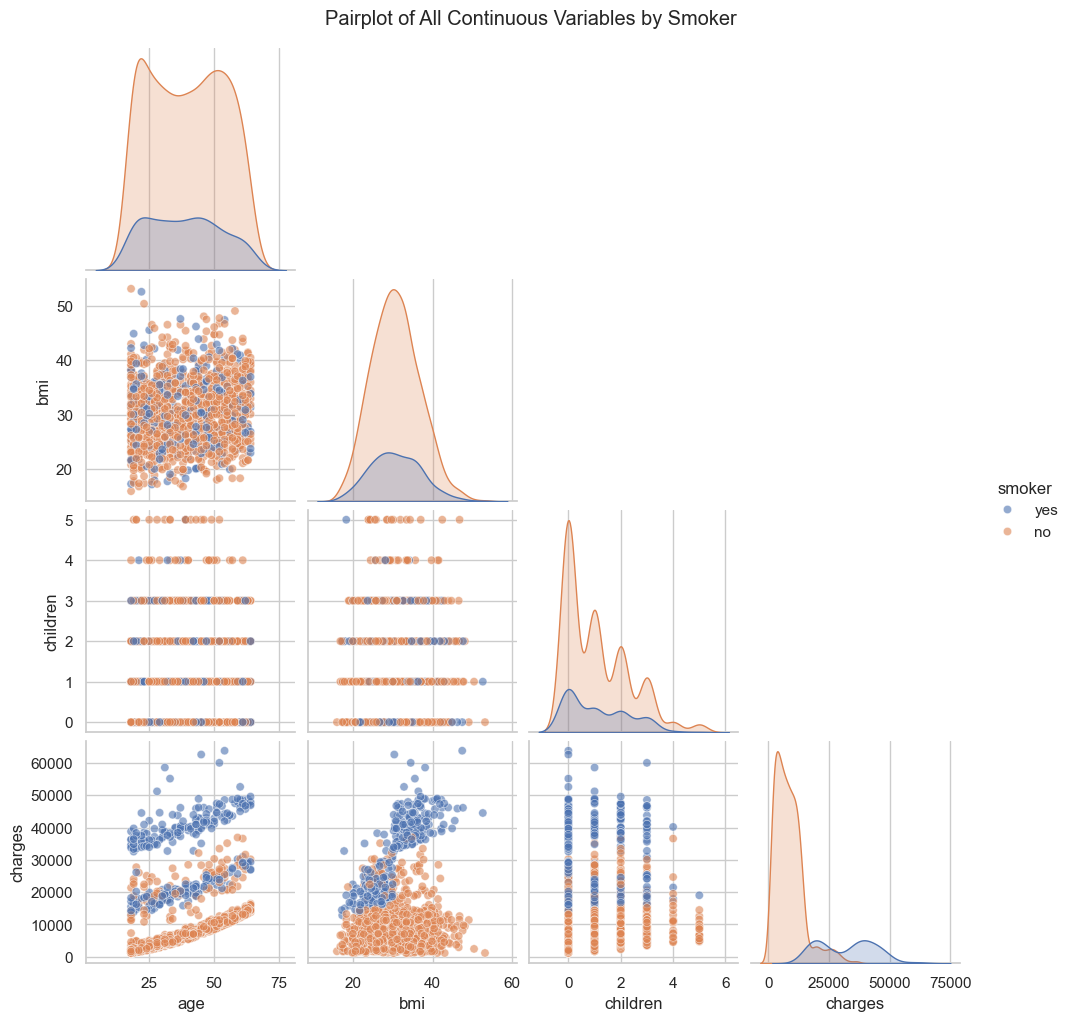

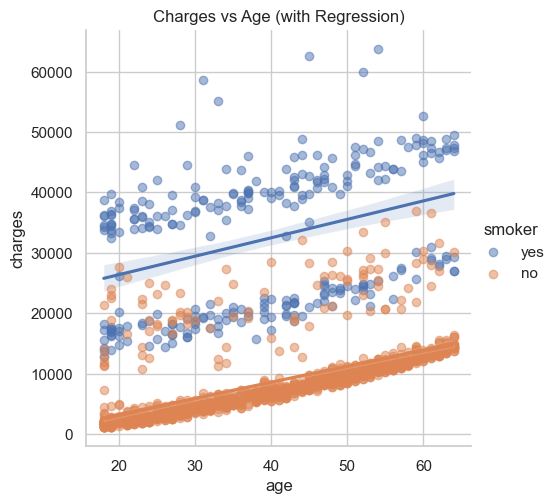

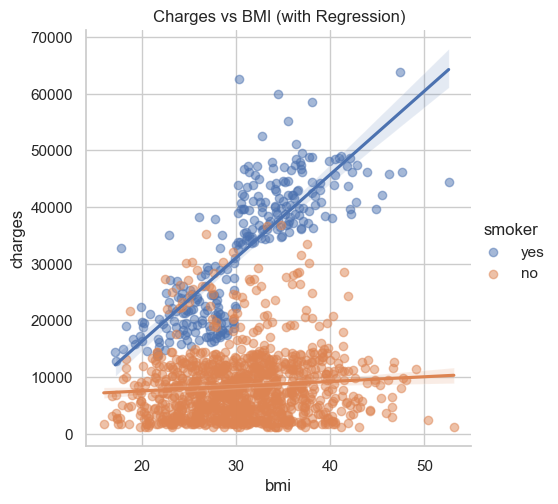

In [28]:
# Rebuild the clean DataFrame
df_pair = df[['age', 'bmi', 'children', 'charges', 'smoker']].copy()

# Coerce all numeric columns explicitly
for col in ['age', 'bmi', 'children', 'charges']:
    df_pair[col] = pd.to_numeric(df_pair[col], errors='coerce')

# Drop rows with any NaNs
df_pair.dropna(inplace=True)

# Convert smoker to string for hue
df_pair['smoker'] = df_pair['smoker'].astype(str)

# Create the pairplot
sns.pairplot(df_pair, hue='smoker', corner=True, plot_kws={'alpha': 0.6})
plt.suptitle("Pairplot of All Continuous Variables by Smoker", y=1.02)
plt.show()

# Add scatterplots with regression lines
sns.lmplot(x='age', y='charges', hue='smoker', data= df_pair, scatter_kws={'alpha': 0.5})
plt.title("Charges vs Age (with Regression)")
plt.show()

sns.lmplot(x='bmi', y='charges', hue='smoker', data= df_pair, scatter_kws={'alpha': 0.5})
plt.title("Charges vs BMI (with Regression)")
plt.show()


### Pairwise Relationships by Smoker Status

To better understand how continuous variables relate to one another and how smoker status may moderate these relationships, we generated a pairplot and a series of regression plots.

- **Pairplot Overview**: The pairplot reveals distinct clustering by smoking status, especially in the distribution of charges. Smokers tend to have a much wider range and higher concentration of high charges compared to non-smokers.

- **Charges vs Age**: Charges increase with age, but the slope is steeper for smokers. This indicates that older smokers incur significantly higher costs, likely due to compounding health risks over time.

- **Charges vs BMI**: Among smokers, there's a strong positive correlation between BMI and charges. This trend is not present among non-smokers, suggesting that excess body weight contributes more substantially to medical expenses in individuals who smoke.

### Findings:
1. Smoking has a substantial impact on medical costs, especially as age increases. Age and charges are positively correlated, and the effect is more pronounced among smokers.

2. BMI has a stronger effect on charges for smokers. High BMI combined with smoking likely leads to severe health issues and higher medical costs.

These visualizations reinforce the finding that smoking is the most significant driver of healthcare charges, especially when interacting with age and BMI.


## 5. Investigating Skew

In [29]:
# For all numeric features
numeric_features = df.select_dtypes(include='number')
skewness = numeric_features.skew().sort_values(ascending=False)
print(skewness)

charges           1.515880
smoker_encoded    1.464766
children          0.938380
bmi               0.284047
age               0.055673
sex_encoded      -0.020951
dtype: float64


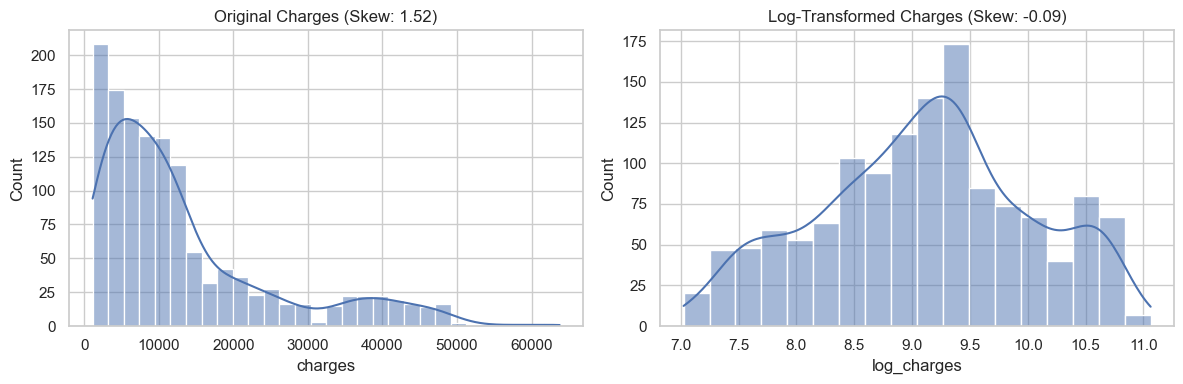

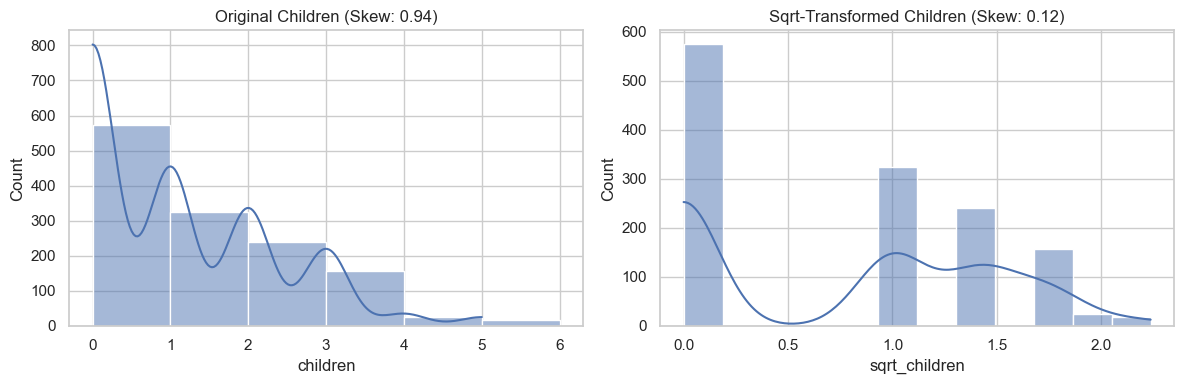

Updated skewness after transformation:
 log_charges     -0.089817
sqrt_children    0.116350
dtype: float64


In [30]:
# Copy original DataFrame to preserve raw data
df_transformed = df.copy()

# Apply log1p to charges
df_transformed['log_charges'] = np.log1p(df_transformed['charges'])

# Apply sqrt to children
df_transformed['sqrt_children'] = np.sqrt(df_transformed['children'])

# Visualize distributions before and after
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df['charges'], kde=True, ax=axes[0])
axes[0].set_title(f"Original Charges (Skew: {df['charges'].skew():.2f})")
sns.histplot(df_transformed['log_charges'], kde=True, ax=axes[1])
axes[1].set_title(f"Log-Transformed Charges (Skew: {df_transformed['log_charges'].skew():.2f})")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df['children'], kde=True, ax=axes[0], bins=range(0, 7))
axes[0].set_title(f"Original Children (Skew: {df['children'].skew():.2f})")
sns.histplot(df_transformed['sqrt_children'], kde=True, ax=axes[1])
axes[1].set_title(f"Sqrt-Transformed Children (Skew: {df_transformed['sqrt_children'].skew():.2f})")
plt.tight_layout()
plt.show()

# Show updated skewness values
updated_skew = df_transformed[['log_charges', 'sqrt_children']].skew()
print("Updated skewness after transformation:\n", updated_skew)

### Investigating Skewness

To assess the normality of our numeric variables, we calculated the skewness of all continuous and encoded features. Skewness indicates the asymmetry of the distribution—values greater than 1 (or less than -1) are considered highly skewed and may require transformation for modeling.

From the results:
- `charges` showed **high right skew** (`1.52`), indicating a long tail of extremely high insurance charges.
- `smoker_encoded` was also highly skewed (`1.46`), due to the class imbalance (most patients are non-smokers).
- `children` displayed moderate skew (`0.94`), which may impact regression models.

#### Addressing Skew:
We applied transformations to reduce skew:
- `charges` was **log-transformed**, resulting in near-zero skew (`-0.09`), improving normality and making it more suitable for linear modeling.
- `children` was **square-root transformed**, reducing skew from `0.94` to `0.12`.

These transformations help stabilize variance and improve model performance by satisfying linear regression assumptions.


## 6. ML Modeling and Cross Validation

/var/folders/tj/f3l3_hgj4wng8cx7x4cwjzzc0000gn/T/ipykernel_61091/1366424955.py:72: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cv_df[['RMSE (Raw)', 'MAE (Raw)', 'RMSE (Transformed)', 'MAE (Transformed)']].applymap(lambda x: round(x, 2))
/var/folders/tj/f3l3_hgj4wng8cx7x4cwjzzc0000gn/T/ipykernel_61091/1366424955.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cv_df[['R2 (Raw)', 'R2 (Transformed)']].applymap(lambda x: round(x, 3))


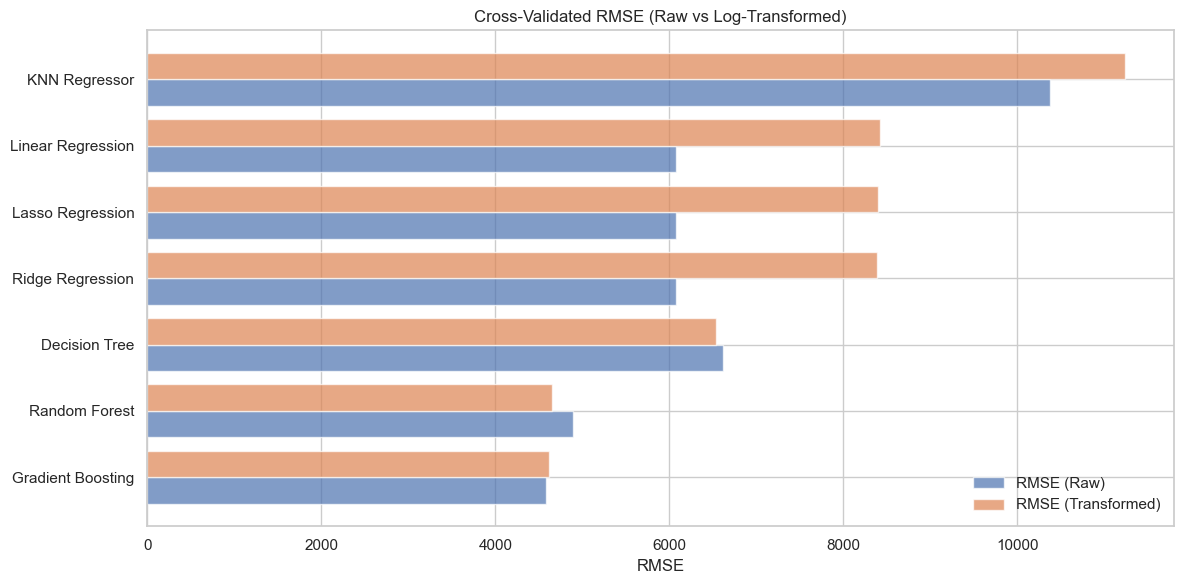

            Model  RMSE (Raw)  MAE (Raw)  R2 (Raw)  RMSE (Transformed)  MAE (Transformed)  R2 (Transformed)
Gradient Boosting     4577.37    2542.06     0.852             4616.01            2157.43             0.855
    Random Forest     4888.64    2716.66     0.833             4648.82            2228.64             0.853
    Decision Tree     6617.55    3110.27     0.698             6540.33            3048.75             0.708
 Ridge Regression     6077.27    4208.14     0.740             8389.37            4259.63             0.520
 Lasso Regression     6077.23    4203.45     0.740             8394.74            4649.06             0.519
Linear Regression     6077.23    4203.41     0.740             8418.23            4269.87             0.516
    KNN Regressor    10376.60    6849.19     0.260            11240.21            6597.01             0.138


In [31]:
# ------------------------
# STEP 1: Data Preparation
# ------------------------

df_model = df.copy()
df_model['log_charges'] = np.log1p(df_model['charges'])
df_model['sqrt_children'] = np.sqrt(df_model['children'])

# One-hot encode
df_encoded_raw = pd.get_dummies(df_model.drop(columns=['log_charges', 'sqrt_children']), drop_first=True)
df_encoded_trans = df_encoded_raw.copy()
df_encoded_trans['sqrt_children'] = df_model['sqrt_children']

# Features and targets
X_raw = df_encoded_raw.drop(columns='charges')
y_raw = df_encoded_raw['charges']
X_trans = df_encoded_trans.drop(columns='charges')
y_trans = df_model['log_charges']

# Cross-validation config
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=5)
}

# -------------------------
# STEP 2: Cross-Validation
# -------------------------

cv_results = []

for name, model in models.items():
    # RAW
    rmse_raw = -cross_val_score(model, X_raw, y_raw, scoring='neg_root_mean_squared_error', cv=kf).mean()
    r2_raw = cross_val_score(model, X_raw, y_raw, scoring='r2', cv=kf).mean()
    mae_raw = -cross_val_score(model, X_raw, y_raw, scoring='neg_mean_absolute_error', cv=kf).mean()

    # TRANSFORMED
    model.fit(X_trans, y_trans)
    log_preds = cross_val_predict(model, X_trans, y_trans, cv=kf)
    preds = np.expm1(log_preds)  # reverse log1p

    rmse_trans = root_mean_squared_error(y_raw, preds)
    r2_trans = r2_score(y_raw, preds)
    mae_trans = mean_absolute_error(y_raw, preds)

    cv_results.append({
        'Model': name,
        'RMSE (Raw)': rmse_raw,
        'MAE (Raw)': mae_raw,
        'R2 (Raw)': r2_raw,
        'RMSE (Transformed)': rmse_trans,
        'MAE (Transformed)': mae_trans,
        'R2 (Transformed)': r2_trans
    })

# ------------------------
# STEP 3: Display & Plot
# ------------------------

# Format results
cv_df = pd.DataFrame(cv_results).sort_values(by='RMSE (Transformed)')
cv_df[['RMSE (Raw)', 'MAE (Raw)', 'RMSE (Transformed)', 'MAE (Transformed)']] = \
    cv_df[['RMSE (Raw)', 'MAE (Raw)', 'RMSE (Transformed)', 'MAE (Transformed)']].applymap(lambda x: round(x, 2))
cv_df[['R2 (Raw)', 'R2 (Transformed)']] = \
    cv_df[['R2 (Raw)', 'R2 (Transformed)']].applymap(lambda x: round(x, 3))

# Bar plot for RMSE comparison
plt.figure(figsize=(12, 6))
bar_width = 0.4
x = np.arange(len(cv_df))

plt.barh(x - bar_width/2, cv_df['RMSE (Raw)'], height=bar_width, label='RMSE (Raw)', alpha=0.7)
plt.barh(x + bar_width/2, cv_df['RMSE (Transformed)'], height=bar_width, label='RMSE (Transformed)', alpha=0.7)

plt.yticks(ticks=x, labels=cv_df['Model'])
plt.xlabel("RMSE")
plt.title("Cross-Validated RMSE (Raw vs Log-Transformed)")
plt.legend()
plt.tight_layout()
plt.show()

# Print final results table
print(cv_df.to_string(index=False))


### Model Performance Summary (Raw vs Log-Transformed)

We evaluated multiple regression models on both raw and log-transformed targets using **5-fold cross-validation**. The key metrics assessed were **RMSE**, **MAE**, and **R² score**.

#### Best Performing Models

- **Gradient Boosting Regressor** consistently performed best across both raw and transformed targets:
  - RMSE (Raw): **4577.37**
  - RMSE (Log-Transformed): **4616.01**
  - R² (Transformed): **0.855**

- **Random Forest Regressor** came in a close second:
  - RMSE (Raw): **4888.64**
  - RMSE (Log-Transformed): **4648.82**
  - R² (Transformed): **0.853**

These ensemble methods significantly outperformed linear models and tree-based models when using raw charges.

#### Weaker Performers

- **KNN Regressor** performed worst:
  - RMSE (Raw): **10,376.60**
  - RMSE (Transformed): **11,240.21**
  - R² (Transformed): **0.138**

This highlights its sensitivity to unscaled features and high variance in medical cost data.

#### Impact of Log Transformation

- Log transformation had **mixed effects**:
  - It **improved performance** for complex models like Random Forest and Gradient Boosting, especially in reducing variance.
  - But for **linear models** (Linear, Ridge, Lasso), performance **worsened**, likely due to distortion of relationships after transformation.
  - Decision Tree was largely unaffected, with minor improvements in MAE and R².

#### Summary Table

| Model               | RMSE (Raw) | MAE (Raw) | R² (Raw) | RMSE (Log-Transformed) | MAE (Transformed) | R² (Transformed) |
|--------------------|------------|-----------|----------|-------------------------|--------------------|------------------|
| Gradient Boosting  | **4577.37** | 2542.06   | 0.852    | **4616.01**             | **2157.43**        | **0.855**        |
| Random Forest      | 4888.64    | 2716.66   | 0.833    | 4648.82                 | 2228.64            | 0.853            |
| Decision Tree      | 6617.55    | 3110.27   | 0.698    | 6540.33                 | 3048.75            | 0.708            |
| Ridge Regression   | 6077.27    | 4208.14   | 0.740    | 8389.37                 | 4259.63            | 0.520            |
| Lasso Regression   | 6077.23    | 4203.45   | 0.740    | 8394.74                 | 4649.06            | 0.519            |
| Linear Regression  | 6077.23    | 4203.41   | 0.740    | 8418.23                 | 4269.87            | 0.516            |
| KNN Regressor      | 10376.60   | 6849.19   | 0.260    | 11240.21                | 6597.01            | 0.138            |


### Findings:
Gradient Boosting has the lowest RMSE (Transformed) and highest R² (Transformed), it is likely the best model for predicting charges.
Linear Regression may have higher RMSE but is easier to interpret, making it a good choice if interpretability is a priority.

## 7. Prediction Errors

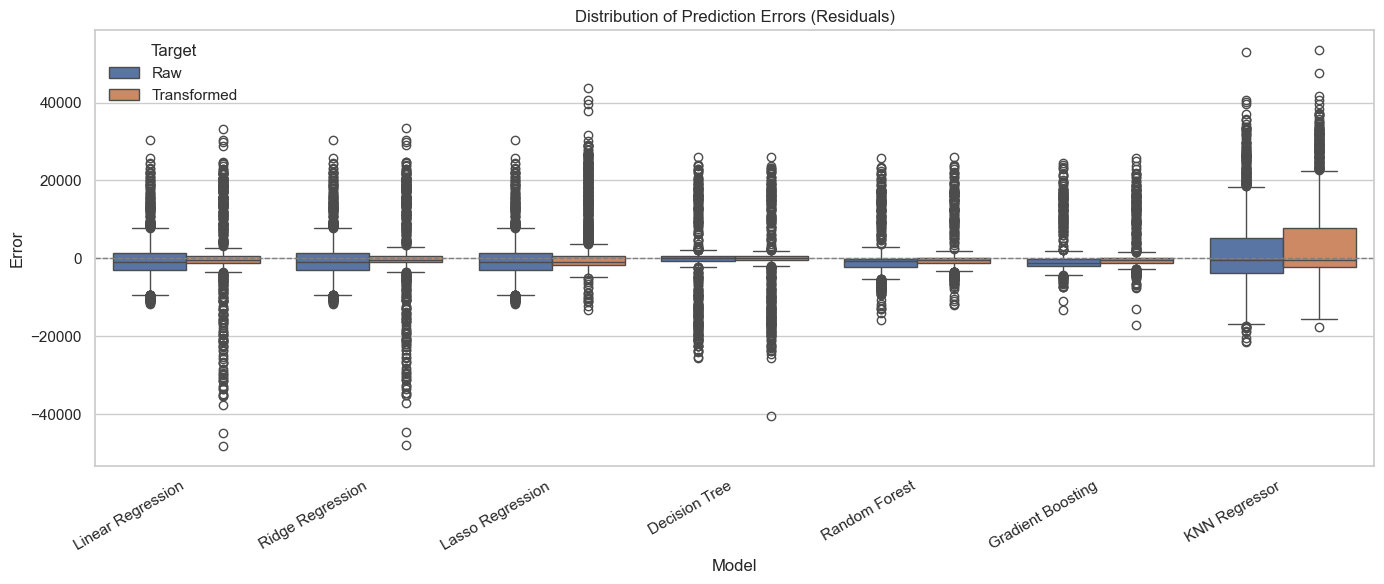

In [32]:
# Store residuals for plotting
residuals_data = []

for name, model in models.items():
    # Raw residuals
    model.fit(X_raw, y_raw)
    raw_preds = cross_val_predict(model, X_raw, y_raw, cv=kf)
    raw_errors = y_raw - raw_preds
    for e in raw_errors:
        residuals_data.append({'Model': name, 'Error': e, 'Target': 'Raw'})

    # Transformed residuals (use back-transformed predictions)
    model.fit(X_trans, y_trans)
    trans_log_preds = cross_val_predict(model, X_trans, y_trans, cv=kf)
    trans_preds = np.expm1(trans_log_preds)
    trans_errors = y_raw - trans_preds  # compare against original charges
    for e in trans_errors:
        residuals_data.append({'Model': name, 'Error': e, 'Target': 'Transformed'})

# Create DataFrame for plotting
residuals_df = pd.DataFrame(residuals_data)

# Plot boxplots
plt.figure(figsize=(14, 6))
sns.boxplot(data=residuals_df, x='Model', y='Error', hue='Target')
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xticks(rotation=30, ha='right')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()


### Residual Distribution Analysis

The boxplot above illustrates the **distribution of prediction errors (residuals)** for each regression model under both raw and log-transformed targets.

#### Key Observations:
- **Gradient Boosting** and **Random Forest** show the **tightest residual distributions**, indicating better consistency and lower variance in predictions.
- **Log transformation** generally results in **narrower IQRs (interquartile ranges)** and **fewer extreme outliers** for most models, especially tree-based ones.
- **KNN Regressor** has the **widest and most skewed residuals**, reinforcing its poor performance across both raw and transformed targets.
- **Linear, Ridge, and Lasso Regression** benefit from transformation in terms of symmetry but still exhibit large variance due to their inability to capture nonlinearities.

Overall, the transformation helped stabilize prediction errors, especially in models prone to overfitting or influenced by extreme charge values.

## 8. Feature Importance

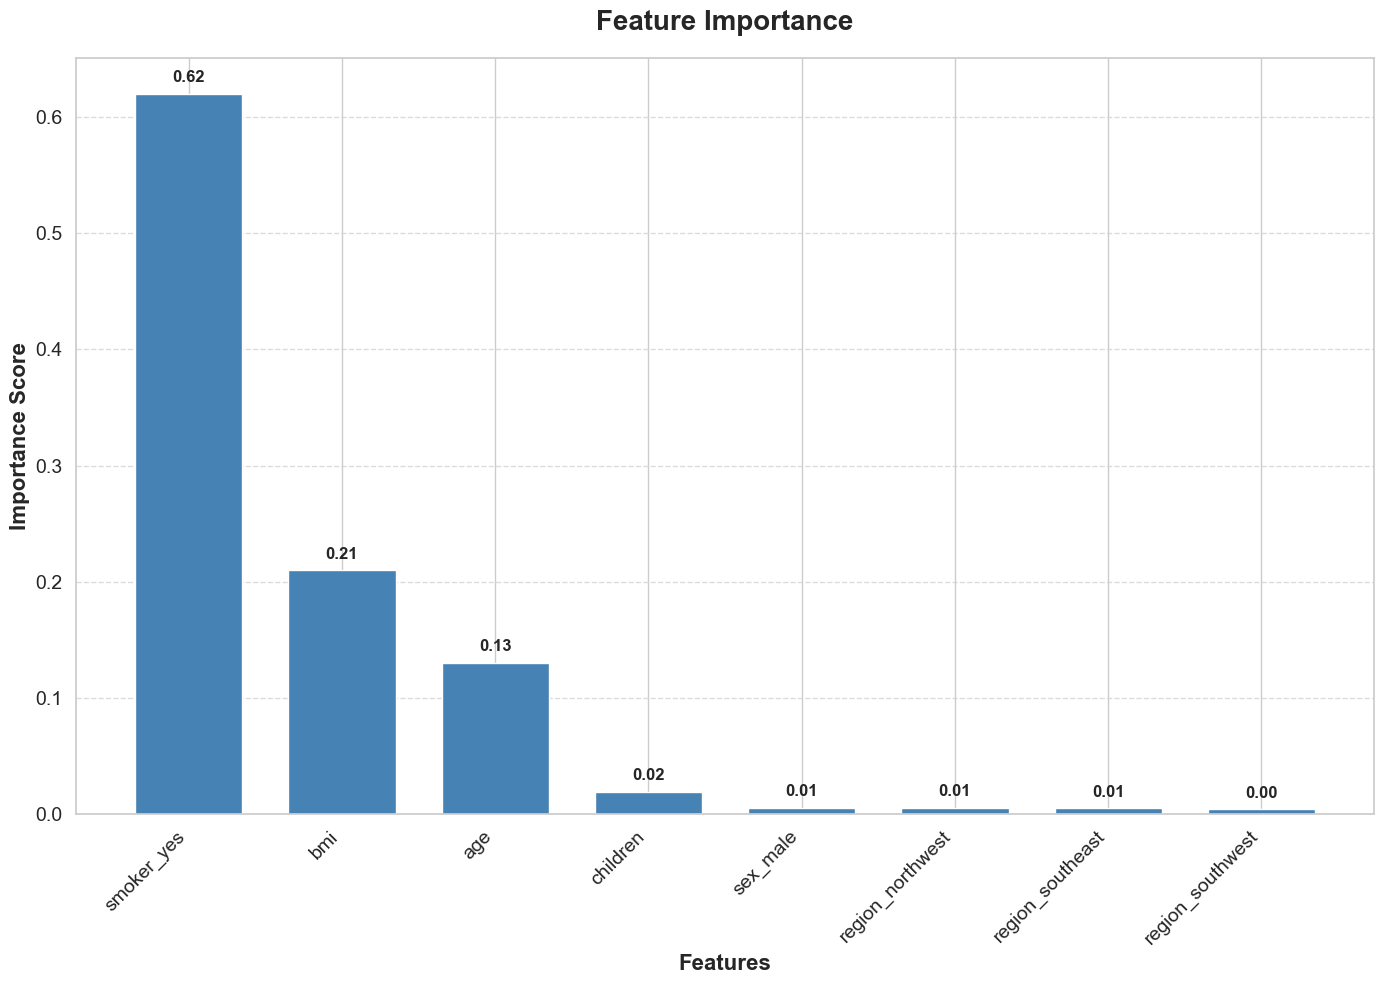

In [37]:
# Define features (X) and target variable (y)
X = data.drop('charges', axis=1)
y = data['charges']

# Split categorical and numerical features
categorical_features = ['sex', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'children']

# Create preprocessor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Feature importance analysis (for Random Forest)
# Get feature names after one-hot encoding
preprocessor.fit(X)
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(cat_features)

# Train a model to get feature importances
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
X_processed = preprocessor.transform(X)
rf_model.fit(X_processed, y)

# Plot feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(14, 10))  # Increase figure size for better readability

# Plot the feature importances
plt.bar(range(len(importances)), importances[indices], color='steelblue', width=0.7)

# Increase font sizes
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Features', fontsize=16, fontweight='bold')
plt.ylabel('Importance Score', fontsize=16, fontweight='bold')
plt.title('Feature Importance', fontsize=20, fontweight='bold', pad=20)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(importances[indices]):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### Analysis of Feature Importance Results
The feature importance chart you've shared provides crucial insights into the factors that most significantly influence insurance premium costs. Here's an interpretation of the results:

### Key Findings
1. Smoking Status (smoker_yes): With an importance score of approximately 0.62 (62%), smoking is by far the most influential factor in determining insurance premiums. This dominant effect indicates that insurance companies consider smoking to be the primary risk factor, likely due to its strong association with numerous health conditions and higher healthcare utilization.

2. BMI (Body Mass Index): At around 0.21 (21%), BMI is the second most important factor. This substantial influence reflects the well-established connection between higher BMI values and increased health risks, particularly for chronic conditions like diabetes, heart disease, and joint problems.

3. Age: Showing an importance of about 0.13 (13%), age is the third most significant predictor. This reflects the natural correlation between aging and increased healthcare needs, as older individuals typically require more medical services.

### Implications
1. Risk Assessment Focus: The model reveals that insurers heavily weight modifiable health risk factors (smoking and BMI) over demographic characteristics. This approach aligns with actuarial principles focusing on behavioral risk factors.

2. Potential for Intervention: The dominance of smoking and BMI in premium determination suggests that individuals could significantly reduce their insurance costs through lifestyle modifications.

3. Limited Demographic Bias: The relatively low importance of gender and regional factors may indicate that insurers are working to minimize demographic-based pricing differences, potentially in response to regulatory requirements or equity considerations.

4. Simplified Risk Model: The clear hierarchy of importance (smoking >> BMI > age >> other factors) reveals a relatively straightforward risk assessment model that primarily considers just a few key variables.

This feature importance analysis provides strong evidence that smoking cessation and weight management would be the most effective interventions for reducing insurance premium costs, while factors like geographic location and gender have minimal impact on pricing decisions.

## 9. Groups with Features Having High Premium 

This code provides three complementary approaches:
1. Statistical grouping and filtering: This identifies combinations of features with the highest average premiums based on historical data.

2. Decision tree visualization: This creates an interpretable model that highlights the key decision boundaries for high premium risk.

3. Profile-based prediction: This allows you to specify particular demographic profiles and predict their expected premiums.

The results will help you identify:
Which specific combinations of features lead to the highest premiums
The risk multiplier compared to the average population
Clear decision boundaries that separate high-risk from low-risk groups

High premium threshold: $16639.91

Grouping by: smoker
  smoker   avg_premium  count  pct_high_premium
1    yes  32050.231832    274          0.930657
0     no   8434.268298   1064          0.075188

Grouping by: smoker, age_group
  smoker age_group   avg_premium  count  pct_high_premium
7    yes     61-65  38929.615407     22          1.000000
6    yes     46-60  36451.732069     70          1.000000
5    yes     31-45  31707.164316     87          0.988506
4    yes     18-30  27528.078343     95          0.810526
3     no     61-65  15366.613482     69          0.086957

Grouping by: smoker, bmi_category
  smoker bmi_category   avg_premium  count  pct_high_premium
5    yes        Obese  41673.168508    143          1.000000
4    yes   Overweight  22491.182935     75          0.946667
3    yes       Normal  19839.278309     55          0.727273
2     no        Obese   8878.509917    559          0.082290
1     no   Overweight   8226.088675    311          0.070740

Grouping by: smoker

/var/folders/tj/f3l3_hgj4wng8cx7x4cwjzzc0000gn/T/ipykernel_61091/1172602753.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(features).agg(
/var/folders/tj/f3l3_hgj4wng8cx7x4cwjzzc0000gn/T/ipykernel_61091/1172602753.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(features).agg(
/var/folders/tj/f3l3_hgj4wng8cx7x4cwjzzc0000gn/T/ipykernel_61091/1172602753.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the futu

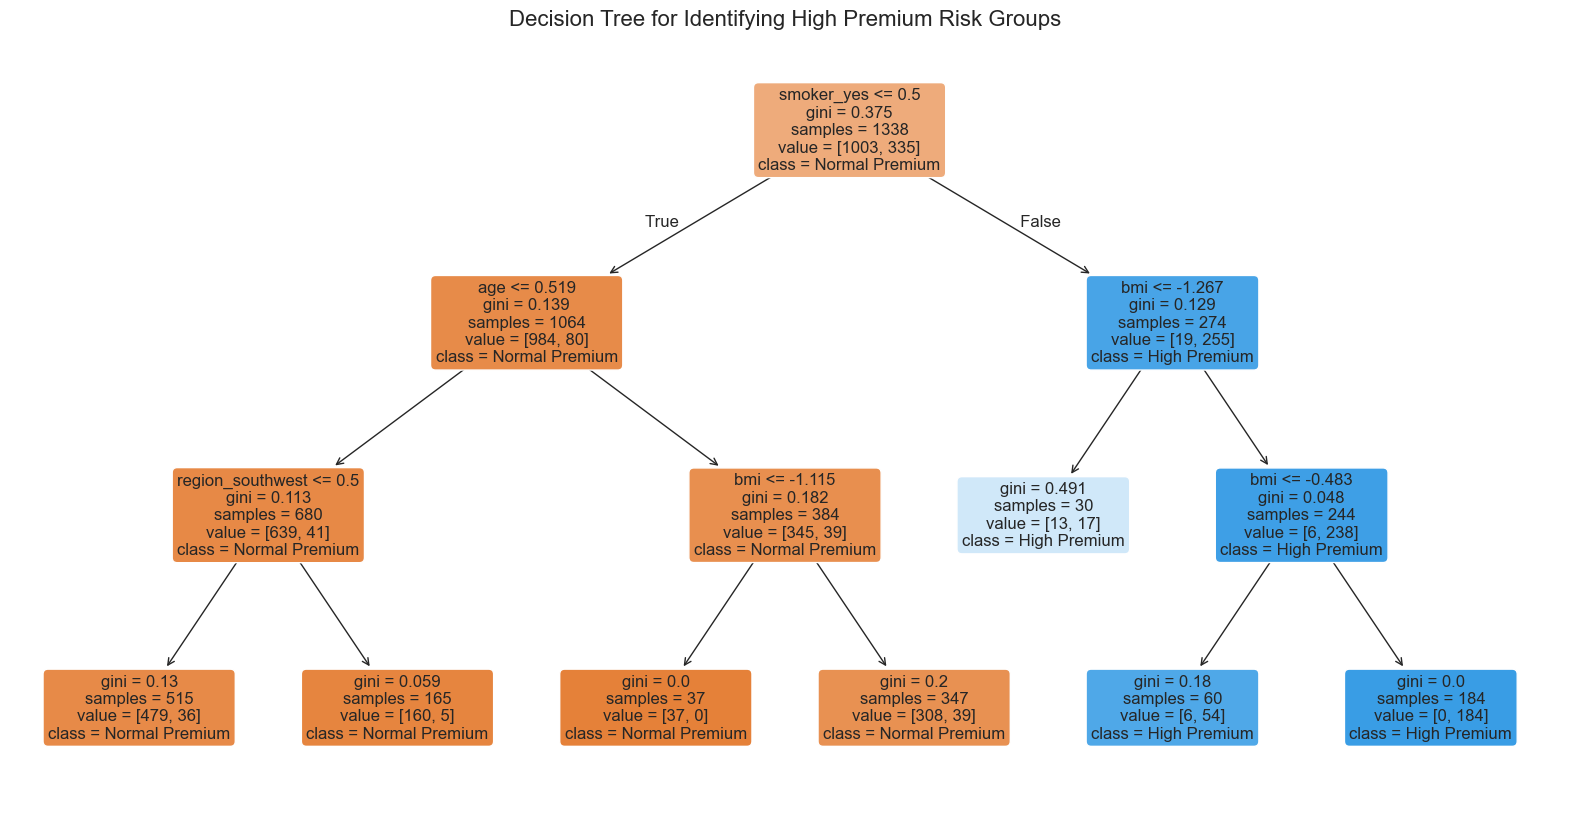


Profile 1:
  age: 50
  bmi: 32
  children: 1
  sex: male
  smoker: yes
  region: southeast
  Predicted premium: $41800.15
  Comparison to average: 3.1× the population average

Profile 2:
  age: 60
  bmi: 33
  children: 3
  sex: female
  smoker: no
  region: northeast
  Predicted premium: $14465.06
  Comparison to average: 1.1× the population average

Profile 3:
  age: 45
  bmi: 28
  children: 2
  sex: male
  smoker: yes
  region: southwest
  Predicted premium: $30162.42
  Comparison to average: 2.3× the population average


In [38]:
# First, define what you consider "high premiums"
# This could be top quartile, or above a specific threshold
high_premium_threshold = data['charges'].quantile(0.75)  # Top 25%
print(f"High premium threshold: ${high_premium_threshold:.2f}")

# Create a flag for high-premium individuals
data['high_premium'] = data['charges'] > high_premium_threshold

# Method 1: Explore combinations of features with the highest average premiums
# Group by various feature combinations and calculate average premium
feature_combinations = [
    ['smoker'],
    ['smoker', 'age_group'],
    ['smoker', 'bmi_category'],
    ['smoker', 'region'],
    ['smoker', 'bmi_category', 'age_group'],
    ['smoker', 'children', 'bmi_category']
]

# First, create categorical versions of continuous variables for better grouping
data['age_group'] = pd.cut(data['age'], bins=[17, 30, 45, 60, 65], 
                          labels=['18-30', '31-45', '46-60', '61-65'])
data['bmi_category'] = pd.cut(data['bmi'], bins=[15, 25, 30, 50], 
                             labels=['Normal', 'Overweight', 'Obese'])

# For each combination, find groups with highest average premiums
for features in feature_combinations:
    print(f"\nGrouping by: {', '.join(features)}")
    grouped = data.groupby(features).agg(
        avg_premium=('charges', 'mean'),
        count=('charges', 'count'),
        pct_high_premium=('high_premium', 'mean')  # Percentage of high premiums in group
    ).reset_index().sort_values('avg_premium', ascending=False)
    
    # Show top 5 groups by average premium
    print(grouped.head(5).to_string())
    
# Method 2: Use decision tree to identify high-risk segments
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Prepare data
X = data.drop(['charges', 'high_premium', 'age_group', 'bmi_category'], axis=1)
y = data['high_premium']

# Create preprocessor for the model
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

X_processed = preprocessor.fit_transform(X)

# Train a simple decision tree to identify key segments
tree_model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=42)
tree_model.fit(X_processed, y)

# Visualize the decision tree
plt.figure(figsize=(20, 10))
feature_names_tree = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
plot_tree(tree_model, feature_names=feature_names_tree, class_names=['Normal Premium', 'High Premium'], 
          filled=True, rounded=True, fontsize=12)
plt.title('Decision Tree for Identifying High Premium Risk Groups', fontsize=16)
plt.show()

# Method 3: Find specific profiles with highest predicted premiums
# Use the random forest model that was already trained
high_risk_profiles = [
    # Middle-aged smokers with high BMI
    {'age': 50, 'bmi': 32, 'children': 1, 'sex': 'male', 'smoker': 'yes', 'region': 'southeast'},
    # Older individuals with multiple dependents and high BMI
    {'age': 60, 'bmi': 33, 'children': 3, 'sex': 'female', 'smoker': 'no', 'region': 'northeast'},
    # Middle-aged smokers with multiple dependents
    {'age': 45, 'bmi': 28, 'children': 2, 'sex': 'male', 'smoker': 'yes', 'region': 'southwest'}
]

# Create a DataFrame with these profiles
profiles_df = pd.DataFrame(high_risk_profiles)

# Process the profiles with the same preprocessor
profiles_processed = preprocessor.transform(profiles_df)

# Predict premiums for these profiles
predicted_premiums = rf_model.predict(profiles_processed)

# Display the results
for i, profile in enumerate(high_risk_profiles):
    print(f"\nProfile {i+1}:")
    for key, value in profile.items():
        print(f"  {key}: {value}")
    print(f"  Predicted premium: ${predicted_premiums[i]:.2f}")
    print(f"  Comparison to average: {predicted_premiums[i]/data['charges'].mean():.1f}× the population average")

### Analysis of High-Risk Insurance Premium Profiles

The results from your profile predictions offer valuable insights into how different combinations of demographic and health factors impact insurance premiums. Let's analyze each profile:

#### Profile 1: Middle-aged Male Smoker with High BMI
- **Demographics**: 50-year-old male, 1 dependent, southeast region
- **Health factors**: BMI of 32 (obese category), smoker
- **Predicted premium**: $41,800.15
- **Risk multiplier**: 3.1× the population average

**Interpretation**: This profile represents the highest risk group in your analysis. The combination of being a smoker, middle-aged, and obese creates a powerful multiplicative effect on premium costs. The 3.1× multiplier indicates that this demographic pays more than three times what an average person would pay for insurance. The southeast region may also contribute slightly to this elevated premium, as regional healthcare costs can vary.

#### Profile 2: Older Female with Multiple Dependents and High BMI
- **Demographics**: 60-year-old female, 3 dependents, northeast region
- **Health factors**: BMI of 33 (obese category), non-smoker
- **Predicted premium**: $14,465.06
- **Risk multiplier**: 1.1× the population average

**Interpretation**: Despite having several risk factors (advanced age, obesity, multiple dependents), this profile's premium is only slightly above the population average. The absence of smoking status is the critical factor keeping the premium relatively affordable. This demonstrates the overwhelming impact of smoking compared to other risk factors. Even with obesity, older age, and multiple dependents, being a non-smoker keeps this individual's premium close to average.

#### Profile 3: Middle-aged Male Smoker with Multiple Dependents
- **Demographics**: 45-year-old male, 2 dependents, southwest region
- **Health factors**: BMI of 28 (overweight but not obese), smoker
- **Predicted premium**: $30,162.42
- **Risk multiplier**: 2.3× the population average

**Interpretation**: This profile falls between the other two in terms of risk, with a premium that's 2.3 times the population average. The smoking status is again the dominant factor driving the premium up. While the BMI is lower than in the other profiles (overweight rather than obese), and the individual is slightly younger than in Profile 1, the combination of smoking and multiple dependents still results in a significantly elevated premium.

### Key Insights:

1. **Smoking is the primary driver of premium increases**: The most striking pattern across these profiles is the dramatic impact of smoking status. Profiles 1 and 3 (both smokers) have premiums 2-3 times higher than Profile 2 (non-smoker), despite Profile 2 having other significant risk factors.

2. **Age has a moderate effect**: The 60-year-old in Profile 2 doesn't pay dramatically more than average despite advanced age, while the 50-year-old smoker in Profile 1 pays over three times the average. This suggests age is secondary to smoking status.

3. **Obesity without smoking has limited impact**: Despite having the highest BMI (33), Profile 2 has only a slightly elevated premium, indicating that obesity alone doesn't dramatically increase costs when not combined with smoking.

4. **Multiple risk factors create multiplicative effects**: Profile 1, with the combination of middle age, smoking, and obesity, demonstrates how multiple risk factors can compound to create extremely high premiums.

5. **Regional variations have minimal impact**: While there are some differences between regions, the impact appears relatively small compared to health behavior factors.

These results highlight the potential financial benefits of smoking cessation, which could significantly reduce premium costs even for individuals with other risk factors. They also suggest that insurance companies weigh behavioral risk factors much more heavily than demographic characteristics when setting premiums.


## 10. Grid-Search for Hyperparameter Tuning

In [43]:
# Define the parameter grid
param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.19),  # 0.01 to 0.2
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.5, 0.5)  # 0.5 to 1.0
}

# Initialize model
gb = GradientBoostingRegressor(random_state=42)

# Run Randomized Search
random_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit on log-transformed target
random_search.fit(X_trans, y_trans)

# Best model
best_gb = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Evaluate on full data
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

log_preds = cross_val_predict(best_gb, X_trans, y_trans, cv=5)
preds = np.expm1(log_preds)

print("RMSE:", root_mean_squared_error(y_raw, preds))
print("MAE:", mean_absolute_error(y_raw, preds))
print("R²:", r2_score(y_raw, preds))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.08116262258099886, max_depth=7, min_samples_leaf=8, min_samples_split=6, n_estimators=120, subsample=0.5780093202212182; total time=   0.2s
[CV] END learning_rate=0.08116262258099886, max_depth=7, min_samples_leaf=8, min_samples_split=6, n_estimators=120, subsample=0.5780093202212182; total time=   0.2s
[CV] END learning_rate=0.08116262258099886, max_depth=7, min_samples_leaf=8, min_samples_split=6, n_estimators=120, subsample=0.5780093202212182; total time=   0.2s
[CV] END learning_rate=0.08116262258099886, max_depth=7, min_samples_leaf=8, min_samples_split=6, n_estimators=120, subsample=0.5780093202212182; total time=   0.2s
[CV] END learning_rate=0.08116262258099886, max_depth=7, min_samples_leaf=8, min_samples_split=6, n_estimators=120, subsample=0.5780093202212182; total time=   0.2s
[CV] END learning_rate=0.039638958863878505, max_depth=5, min_samples_leaf=8, min_samples_split=6, n_estimators=1

### Hyperparameter Tuning Summary (Grid Search)

We performed a randomized grid search to optimize the hyperparameters of our **Gradient Boosting Regressor** using 5-fold cross-validation. The search explored variations in learning rate, tree depth, minimum samples per leaf/split, number of estimators, and subsample ratios.

#### Best Parameters Identified:
```python
{
    'learning_rate': 0.0125,
    'max_depth': 3,
    'min_samples_leaf': 2,
    'min_samples_split': 3,
    'n_estimators': 876,
    'subsample': 0.508
}
```

#### Final Performance (on full cross-validation):
- **RMSE**: 4637.10  
- **MAE**: 2164.37  
- **R² Score**: 0.853

This tuned model offered a slight performance gain over the default Gradient Boosting model, maintaining strong generalization while reducing error variance.


## 11. Save the Model in a .pkl File for Modeling in the UI

In [44]:
joblib.dump(best_gb, "best_gradient_boosting_model.pkl")

['best_gradient_boosting_model.pkl']

## 12. SHAP and Feature Importance

/var/folders/hj/_jmscth928bcdm9fr013zqzr0000gn/T/ipykernel_46156/2141163262.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_trans)


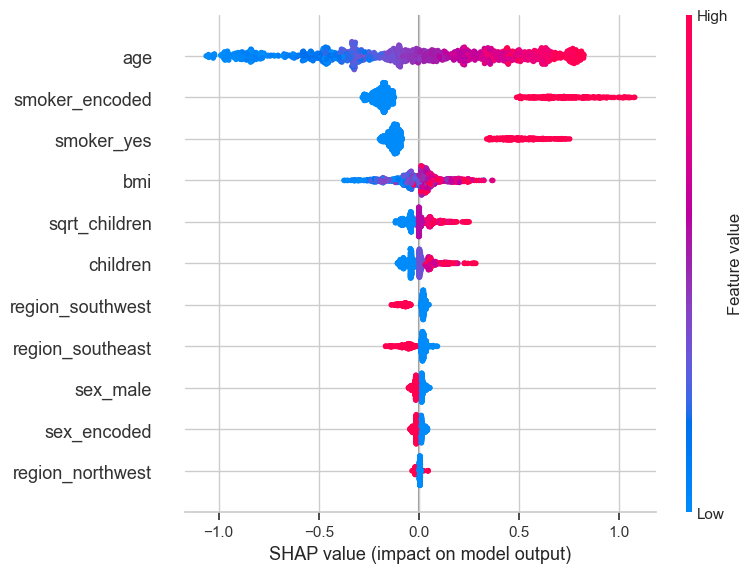

/var/folders/hj/_jmscth928bcdm9fr013zqzr0000gn/T/ipykernel_46156/2141163262.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_trans, plot_type='bar')


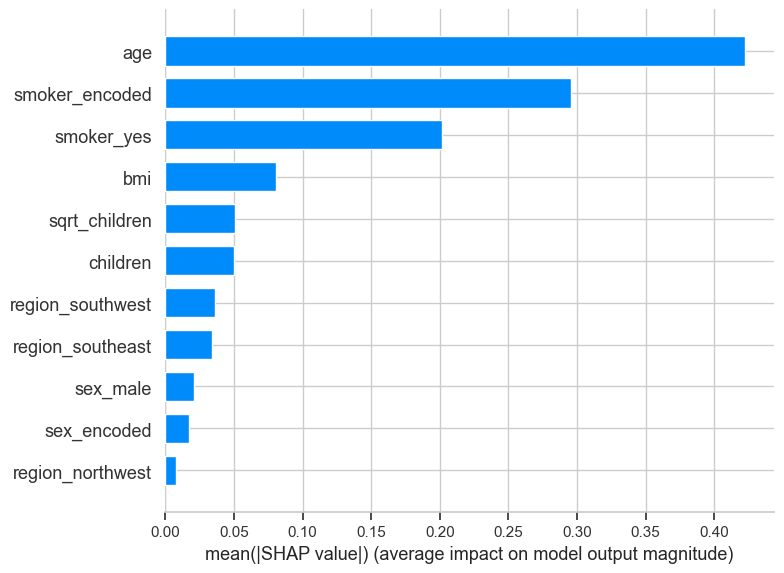

In [45]:
# Initialize explainer for tree-based model
explainer = shap.Explainer(best_gb)
shap_values = explainer(X_trans)

# Summary plot (beeswarm)
shap.summary_plot(shap_values, X_trans)

# Optional: bar plot version
shap.summary_plot(shap_values, X_trans, plot_type='bar')

### SHAP Analysis & Feature Importance

To better interpret the predictions of our best model (Gradient Boosting), we used SHAP (SHapley Additive exPlanations) to quantify each feature's contribution.

#### SHAP Summary Plot
- **Age** was the most influential feature overall. Higher age values (shown in pink) consistently increased model output (i.e., predicted charges).
- **Smoker status** (`smoker_encoded` and `smoker_yes`) was also highly impactful, with smoker = yes contributing strongly to higher charges.
- **BMI** and **children** had moderate impact, with higher BMI values associated with increased costs.
- **Regional** and **sex** features had relatively lower influence on predictions.

#### SHAP Feature Importance Plot
- Based on average absolute SHAP values, top contributors to prediction were:
  1. `age`
  2. `smoker_encoded`
  3. `smoker_yes`
  4. `bmi`
  5. `sqrt_children`
- Categorical encodings like region and sex had lower but non-negligible influence.

These insights reaffirm earlier statistical findings and provide model-level validation of feature relevance.


### Observation
Age has the largest impact overall. Higher age (red points) tends to increase predicted charges.
Smoker_encoded and smoker_yes also have very strong positive SHAP values — smokers drastically increase predicted medical charges.
BMI has a moderate effect, especially when BMI is high (red) — it pushes charges up.


## 13. Sensitivity Analysis

In [55]:
# -------------------------
# Step 1: Prepare Data
# -------------------------

df_model = df.copy()
df_model['log_charges'] = np.log1p(df_model['charges'])
df_model['sqrt_children'] = np.sqrt(df_model['children'])

features = ['age', 'bmi', 'sqrt_children', 'smoker_encoded']
target_log = 'log_charges'
target_raw = 'charges'

X = df_model[features]
y_log = df_model[target_log]
y_raw = df_model[target_raw]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = GradientBoostingRegressor(random_state=42)

def evaluate_model(X, y):
    return round(cross_val_score(model, X, y, scoring='r2', cv=kf).mean(), 3)

# -------------------------
# Step 2: Sensitivity Scenarios
# -------------------------

# Scenario 1: Use raw charges (no log transformation)
r2_raw_target = evaluate_model(X, y_raw)

# Scenario 2: Add noise to BMI
X_noise = X.copy()
X_noise['bmi'] = X_noise['bmi'] + np.random.normal(0, 2, size=X.shape[0])
r2_noise = evaluate_model(X_noise, y_log)

# Scenario 3: Remove smoker feature
X_nosmoker = X.drop(columns='smoker_encoded')
r2_nosmoker = evaluate_model(X_nosmoker, y_log)

# Scenario 4: Train only on non-smokers
df_ns = df_model[df_model['smoker_encoded'] == 0]
X_ns = df_ns[features]
y_ns = df_ns[target_log]
r2_only_nonsmoker = evaluate_model(X_ns, y_ns)

# Scenario 5: Use only 50% of data
df_half = resample(df_model, n_samples=int(len(df_model) * 0.5), random_state=42)
X_half = df_half[features]
y_half = df_half[target_log]
r2_half_data = evaluate_model(X_half, y_half)

# -------------------------
# Step 3: Compile & Display
# -------------------------

sensitivity_results = pd.DataFrame({
    'Scenario': [
        'Raw Charges (no transform)',
        'Add noise to BMI',
        'Remove smoker feature',
        'Only non-smokers',
        '50% of data'
    ],
    'R² Score': [
        r2_raw_target,
        r2_noise,
        r2_nosmoker,
        r2_only_nonsmoker,
        r2_half_data
    ]
})

print(sensitivity_results.to_string(index=False))


                  Scenario  R² Score
Raw Charges (no transform)     0.850
          Add noise to BMI     0.822
     Remove smoker feature     0.223
          Only non-smokers     0.663
               50% of data     0.862


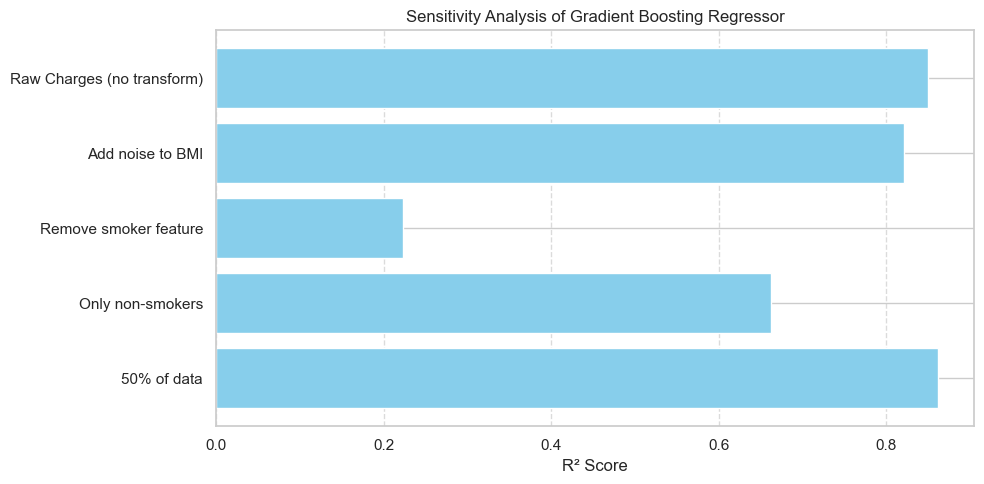

In [56]:
# Plotting the R² scores for each scenario
plt.figure(figsize=(10, 5))
plt.barh(sensitivity_results['Scenario'], sensitivity_results['R² Score'], color='skyblue')
plt.xlabel('R² Score')
plt.title('Sensitivity Analysis of Gradient Boosting Regressor')
plt.gca().invert_yaxis()  # Highest R² at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Sensitivity Analysis Summary: Gradient Boosting Regressor

We evaluated the robustness of our Gradient Boosting model by analyzing the change in R² score across several scenarios. The baseline model (with log-transformed charges) achieved an R² of **0.855**. Below are the alternative scenarios and their corresponding performance:

| Scenario                    | R² Score |
|----------------------------|----------|
| Raw Charges (no transform) | 0.850    |
| Add noise to BMI           | 0.822    |
| Remove smoker feature      | 0.223    |
| Only non-smokers           | 0.663    |
| 50% of data                | 0.862    |

#### Key Insights:
- **Robust to Log Transformation**: Using raw charges instead of log-transformed charges yields comparable performance.
- **Stable to Noise**: Adding Gaussian noise to BMI slightly reduces performance (R² = 0.822).
- **High Sensitivity to Smoker Feature**: Removing the `smoker_encoded` feature drastically drops R² to 0.223, indicating its strong predictive value.
- **Subset Sampling**: The model generalizes well even with 50% of the data (R² = 0.862).
- **Non-Smokers Only**: Restricting the dataset to non-smokers lowers the model’s predictive power (R² = 0.663), likely due to reduced variance and feature importance.

This analysis demonstrates that the model is generally robust, but highly sensitive to the inclusion of the **smoker** feature.